In [138]:
from functions import *
import seaborn as sns

In [139]:
variable_set_mapping = {
    'lst': 'LST',
    'lst, ndvi': 'LST + NDVI',
    'altitude, direction, lst, ndvi, slope': 'All Image Features',
    'discharge, lat, lon, lst, month, ndvi': 'LST + NDVI + Non-image Features',
    'altitude, coords, direction, discharge, lst, month, ndvi, slope': 'Full Features'
}


In [140]:
def validate_dataframe(df, column="Split_id"):
    """
    Validates if the DataFrame has exactly 5 rows and if the specified column contains
    at least one row for each value from 1 to 5. Also prints any extra or duplicate rows
    based on the specified column.

    Parameters:
    - df (pd.DataFrame): DataFrame to validate
    - column (str): Name of the column to check (default: 'Split_id')

    Returns:
    - bool: True if the DataFrame meets the conditions, False otherwise
    """
    # Check if the DataFrame has exactly 5 rows
    if len(df) != 5:
        print("The DataFrame does not have exactly 5 rows.")
        return False

    # Check if it contains exactly the values 1 to 5 in the specified column
    required_splits = set(range(1, 6))
    actual_splits = set(df[column].unique())

    if not required_splits.issubset(actual_splits):
        print("Missing values in the column:", required_splits - actual_splits)
        return False

    # Check for extra or duplicate rows
    extra_or_duplicates = df[df.duplicated(subset=[column], keep=False) | ~df[column].isin(required_splits)]
    if not extra_or_duplicates.empty:
        print("Extra or duplicate rows found:")
        print(extra_or_duplicates)
        return False

    return True

# Hyperparameter experimentation

In [141]:
model= 'simple_CNN'
simple_cnn = pd.read_excel(f'../official_results/{model}_results.xlsx')
simple_cnn['Normalized Variables'] = simple_cnn['Variables'].apply(
    lambda x: ', '.join(sorted(x.split(', '))))
print(simple_cnn['Normalized Variables'].unique())
simple_cnn['Normalized Variables'] = simple_cnn['Normalized Variables'].map(variable_set_mapping)

['lst' 'lst, ndvi' 'altitude, direction, lst, ndvi, slope'
 'altitude, coords, direction, discharge, lst, month, ndvi, slope']


In [142]:
simple_cnn[simple_cnn['nº samples'].isin(['4866 images, all augmented', '4854 images, all augmented',
       '4836 images, all augmented', '4812 images, all augmented'])]

,Experiment,RMSE,Variables,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
182,183,4.210135,lst,1,Adam,"4866 images, all augmented",128,56 of 300,2024-12-19,13:56:01,507.44,RMSE,128,LST
183,183,4.576049,lst,2,Adam,"4854 images, all augmented",128,43 of 300,2024-12-19,14:02:36,383.52,RMSE,128,LST
184,183,4.495413,lst,3,Adam,"4866 images, all augmented",128,50 of 300,2024-12-19,14:10:16,451.03,RMSE,128,LST
185,183,4.306352,lst,4,Adam,"4836 images, all augmented",128,46 of 300,2024-12-19,14:17:15,412.40,RMSE,128,LST
186,183,4.541492,lst,5,Adam,"4812 images, all augmented",128,52 of 300,2024-12-19,14:25:10,468.29,RMSE,128,LST


In [143]:
#simple_cnn.to_excel(f'../official_results/{model}_results.xlsx', index=False)
simple_cnn['nº samples'].unique()

array(['826 images', '784 images', '1568 images + 50176 augmented',
       '1081 images', '1405 images', '1059 images', '1359 images',
       '1026 images', '1290 images', '982 images', '1198 images',
       '1729 images', '1659 images', '1554 images', '1414 images',
       '4866 images, all augmented', '4854 images, all augmented',
       '4836 images, all augmented', '4812 images, all augmented',
       '24330 images, all augmented 5x', '24270 images, all augmented 5x',
       '24180 images, all augmented 5x', '24060 images, all augmented 5x'],
      dtype=object)

### Check best experiment combination + full experiments

In [144]:
grouping_columns = [col for col in simple_cnn.columns if col not in ['Date','Split_id', 'RMSE','Duration','Time','Experiment','Epochs','Variables']]

experiment_mean_rmse = simple_cnn.groupby(grouping_columns)['RMSE'].mean().reset_index()
print('Best experiment combination:')
print(experiment_mean_rmse.loc[experiment_mean_rmse['RMSE'].idxmin()])
print('\nFull experiments combination:', len(experiment_mean_rmse))
experiment_mean_rmse.sort_values("RMSE").head(10)

Best experiment combination:
Optimizer                                     Adam
nº samples              4836 images, all augmented
Batch size                                     128
Loss                                          RMSE
Resolution                                     128
Normalized Variables                           LST
RMSE                                      4.306352
Name: 17, dtype: object

Full experiments combination: 51


,Optimizer,nº samples,Batch size,Loss,Resolution,Normalized Variables,RMSE
17,Adam,"4836 images, all augmented",128,RMSE,128,LST,4.306352
31,Adam,784 images,128,RMSE,128,All Image Features,4.332551
19,Adam,"4866 images, all augmented",128,RMSE,128,LST,4.352774
33,Adam,784 images,128,RMSE,128,LST,4.392362
41,Adam,784 images,256,RMSE,128,LST,4.392504
37,Adam,784 images,128,RMSE_sensitive,128,LST,4.395369
36,Adam,784 images,128,RMSE_sensitive,128,All Image Features,4.401545
35,Adam,784 images,128,RMSE_focal,128,LST,4.427882
9,Adam,1568 images + 50176 augmented,128,RMSE,64,LST,4.432833
44,Adam,826 images,128,RMSE,64,LST,4.448089


In [145]:
# Agrupar por las columnas especificadas
grouped_data = simple_cnn.groupby(grouping_columns)

# Crear un diccionario donde cada clave es una combinación y el valor son las filas originales
experiments_by_group = {name: group for name, group in grouped_data}

# Mostrar los primeros grupos (por ejemplo, las primeras 3 combinaciones)
for name, group in list(experiments_by_group.items())[:3]:
    print(f"Combination: {name}")
    print(group)
    print("\n" + "-"*50 + "\n")

# Si quieres combinar todo en un DataFrame grande para inspección:
grouped_with_mean = grouped_data['RMSE'].mean().reset_index()
grouped_with_mean['Experiments'] = grouped_with_mean[grouping_columns].apply(
    lambda row: experiments_by_group[tuple(row)], axis=1
)

grouped_with_mean.sort_values('RMSE')


Combination: ('Adam', '1026 images', 128, 'RMSE', 128, 'LST')
     Experiment     RMSE Variables  Split_id Optimizer   nº samples  \
173         168  4.57183       lst         4      Adam  1026 images   

     Batch size     Epochs        Date      Time  Duration  Loss  Resolution  \
173         128  85 of 300  2024-12-19  11:21:14    197.68  RMSE         128   

    Normalized Variables  
173                  LST  

--------------------------------------------------

Combination: ('Adam', '1059 images', 128, 'RMSE', 128, 'LST')
     Experiment     RMSE Variables  Split_id Optimizer   nº samples  \
169         168  4.70849       lst         2      Adam  1059 images   

     Batch size     Epochs        Date      Time  Duration  Loss  Resolution  \
169         128  58 of 300  2024-12-19  11:15:22    137.07  RMSE         128   

    Normalized Variables  
169                  LST  

--------------------------------------------------

Combination: ('Adam', '1081 images', 128, 'RMSE', 128,

,Optimizer,nº samples,Batch size,Loss,Resolution,Normalized Variables,RMSE,Experiments
17,Adam,"4836 images, all augmented",128,RMSE,128,LST,4.306352,Experiment RMSE Variables Split_id ...
31,Adam,784 images,128,RMSE,128,All Image Features,4.332551,Experiment RMSE ...
19,Adam,"4866 images, all augmented",128,RMSE,128,LST,4.352774,Experiment RMSE Variables Split_id ...
33,Adam,784 images,128,RMSE,128,LST,4.392362,Experiment RMSE Variables Split_id O...
41,Adam,784 images,256,RMSE,128,LST,4.392504,Experiment RMSE Variables Split_id ...
37,Adam,784 images,128,RMSE_sensitive,128,LST,4.395369,Experiment RMSE Variables Split_id ...
36,Adam,784 images,128,RMSE_sensitive,128,All Image Features,4.401545,Experiment RMSE ...
35,Adam,784 images,128,RMSE_focal,128,LST,4.427882,Experiment RMSE Variables Split_id ...
9,Adam,1568 images + 50176 augmented,128,RMSE,64,LST,4.432833,Experiment RMSE Variables Split_id O...
44,Adam,826 images,128,RMSE,64,LST,4.448089,Experiment RMSE Variables Split_id O...


In [146]:
grouped_with_mean.Experiments.iloc[15]


,Experiment,RMSE,Variables,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
187,188,4.834912,lst,1,Adam,"24330 images, all augmented 5x",128,37 of 300,2024-12-19,15:24:34,1607.71,RMSE,128,LST
189,188,4.877460,lst,3,Adam,"24330 images, all augmented 5x",128,40 of 300,2024-12-19,16:19:24,1733.85,RMSE,128,LST


## Data Cleaness vs Batch Size Experimentation

In [147]:
var = 'LST'
res=64
samples = 826
filtered_data=simple_cnn[(simple_cnn['nº samples']==f'{samples} images')&(simple_cnn['Resolution']==res)&\
            (simple_cnn['Normalized Variables']==var)&(simple_cnn.Loss=='RMSE')&(simple_cnn.Optimizer=='Adam')]
samples = 784
filtered_data_2=simple_cnn[(simple_cnn['nº samples']==f'{samples} images')&(simple_cnn['Resolution']==res)&\
            (simple_cnn['Normalized Variables']==var)&(simple_cnn.Loss=='RMSE')&(simple_cnn.Optimizer=='Adam')]

samples = 803
filtered_data_3=simple_cnn[(simple_cnn['nº samples']==f'{samples} images')&(simple_cnn['Resolution']==res)&\
            (simple_cnn['Normalized Variables']==var)&(simple_cnn.Loss=='RMSE')&(simple_cnn.Optimizer=='Adam')]


In [148]:
for bs in filtered_data['Batch size'].unique():
    print(validate_dataframe(filtered_data[filtered_data['Batch size']==bs]))
    if not validate_dataframe(filtered_data[filtered_data['Batch size']==bs]):
        print(filtered_data[filtered_data['Batch size']==bs])
        
    print(validate_dataframe(filtered_data_2[filtered_data_2['Batch size']==bs]))
    if not validate_dataframe(filtered_data_2[filtered_data_2['Batch size']==bs]):
        print(filtered_data_2[filtered_data_2['Batch size']==bs])


The DataFrame does not have exactly 5 rows.
False
The DataFrame does not have exactly 5 rows.
    Experiment      RMSE Variables  Split_id Optimizer  nº samples  \
0            1  4.629602       lst         1      Adam  826 images   
1            1  4.989918       lst         2      Adam  826 images   
2            1  4.538962       lst         3      Adam  826 images   
3            1  4.762443       lst         4      Adam  826 images   
4            1  4.794312       lst         5      Adam  826 images   
20          21  4.945305       lst         1      Adam  826 images   

    Batch size      Epochs        Date      Time  Duration  Loss  Resolution  \
0           32  116 of 300  2024-11-29  17:52:05    318.86  RMSE          64   
1           32  115 of 300  2024-11-29  17:57:18    312.11  RMSE          64   
2           32  105 of 300  2024-11-29  18:02:01    283.29  RMSE          64   
3           32   82 of 300  2024-11-29  18:05:42    219.82  RMSE          64   
4           32 

In [149]:
filtered_data_2 = filtered_data_2.copy()
filtered_data = filtered_data.copy()


filtered_data_2['Dataset'] = '100% Clean'
filtered_data['Dataset'] = '90% Clean'

# Combine the two datasets for plotting
combined_data = pd.concat([filtered_data, filtered_data_2])

# Calculate the standard deviation for each group (Loss)
stds = combined_data.groupby(['Batch size', 'Dataset'])['RMSE'].std()

# Display the results
print("Standard deviation by Loss:")
print(stds)

# Identify the set with the least variation
min_variation_loss = stds.idxmin()
print(f"The set with the least variation is: {min_variation_loss} with a standard deviation of {stds[min_variation_loss]:.3f}")

latex_table = stds.reset_index().rename(columns={'Loss': 'Loss Function', 'RMSE': 'Standard Deviation'}).to_latex(
    index=False, float_format="%.3f", caption="Standard Deviation of RMSE by Loss Function", label="tab:rmse_std"
)
print()
print(latex_table)

Standard deviation by Loss:
Batch size  Dataset   
32          100% Clean    0.150995
            90% Clean     0.174677
64          100% Clean    0.162870
            90% Clean     0.219023
128         100% Clean    0.203212
            90% Clean     0.186057
256         100% Clean    0.270221
            90% Clean     0.185227
Name: RMSE, dtype: float64
The set with the least variation is: (32, '100% Clean') with a standard deviation of 0.151

\begin{table}
\caption{Standard Deviation of RMSE by Loss Function}
\label{tab:rmse_std}
\begin{tabular}{rlr}
\toprule
Batch size & Dataset & Standard Deviation \\
\midrule
32 & 100% Clean & 0.151 \\
32 & 90% Clean & 0.175 \\
64 & 100% Clean & 0.163 \\
64 & 90% Clean & 0.219 \\
128 & 100% Clean & 0.203 \\
128 & 90% Clean & 0.186 \\
256 & 100% Clean & 0.270 \\
256 & 90% Clean & 0.185 \\
\bottomrule
\end{tabular}
\end{table}



/Users/ruthparajo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


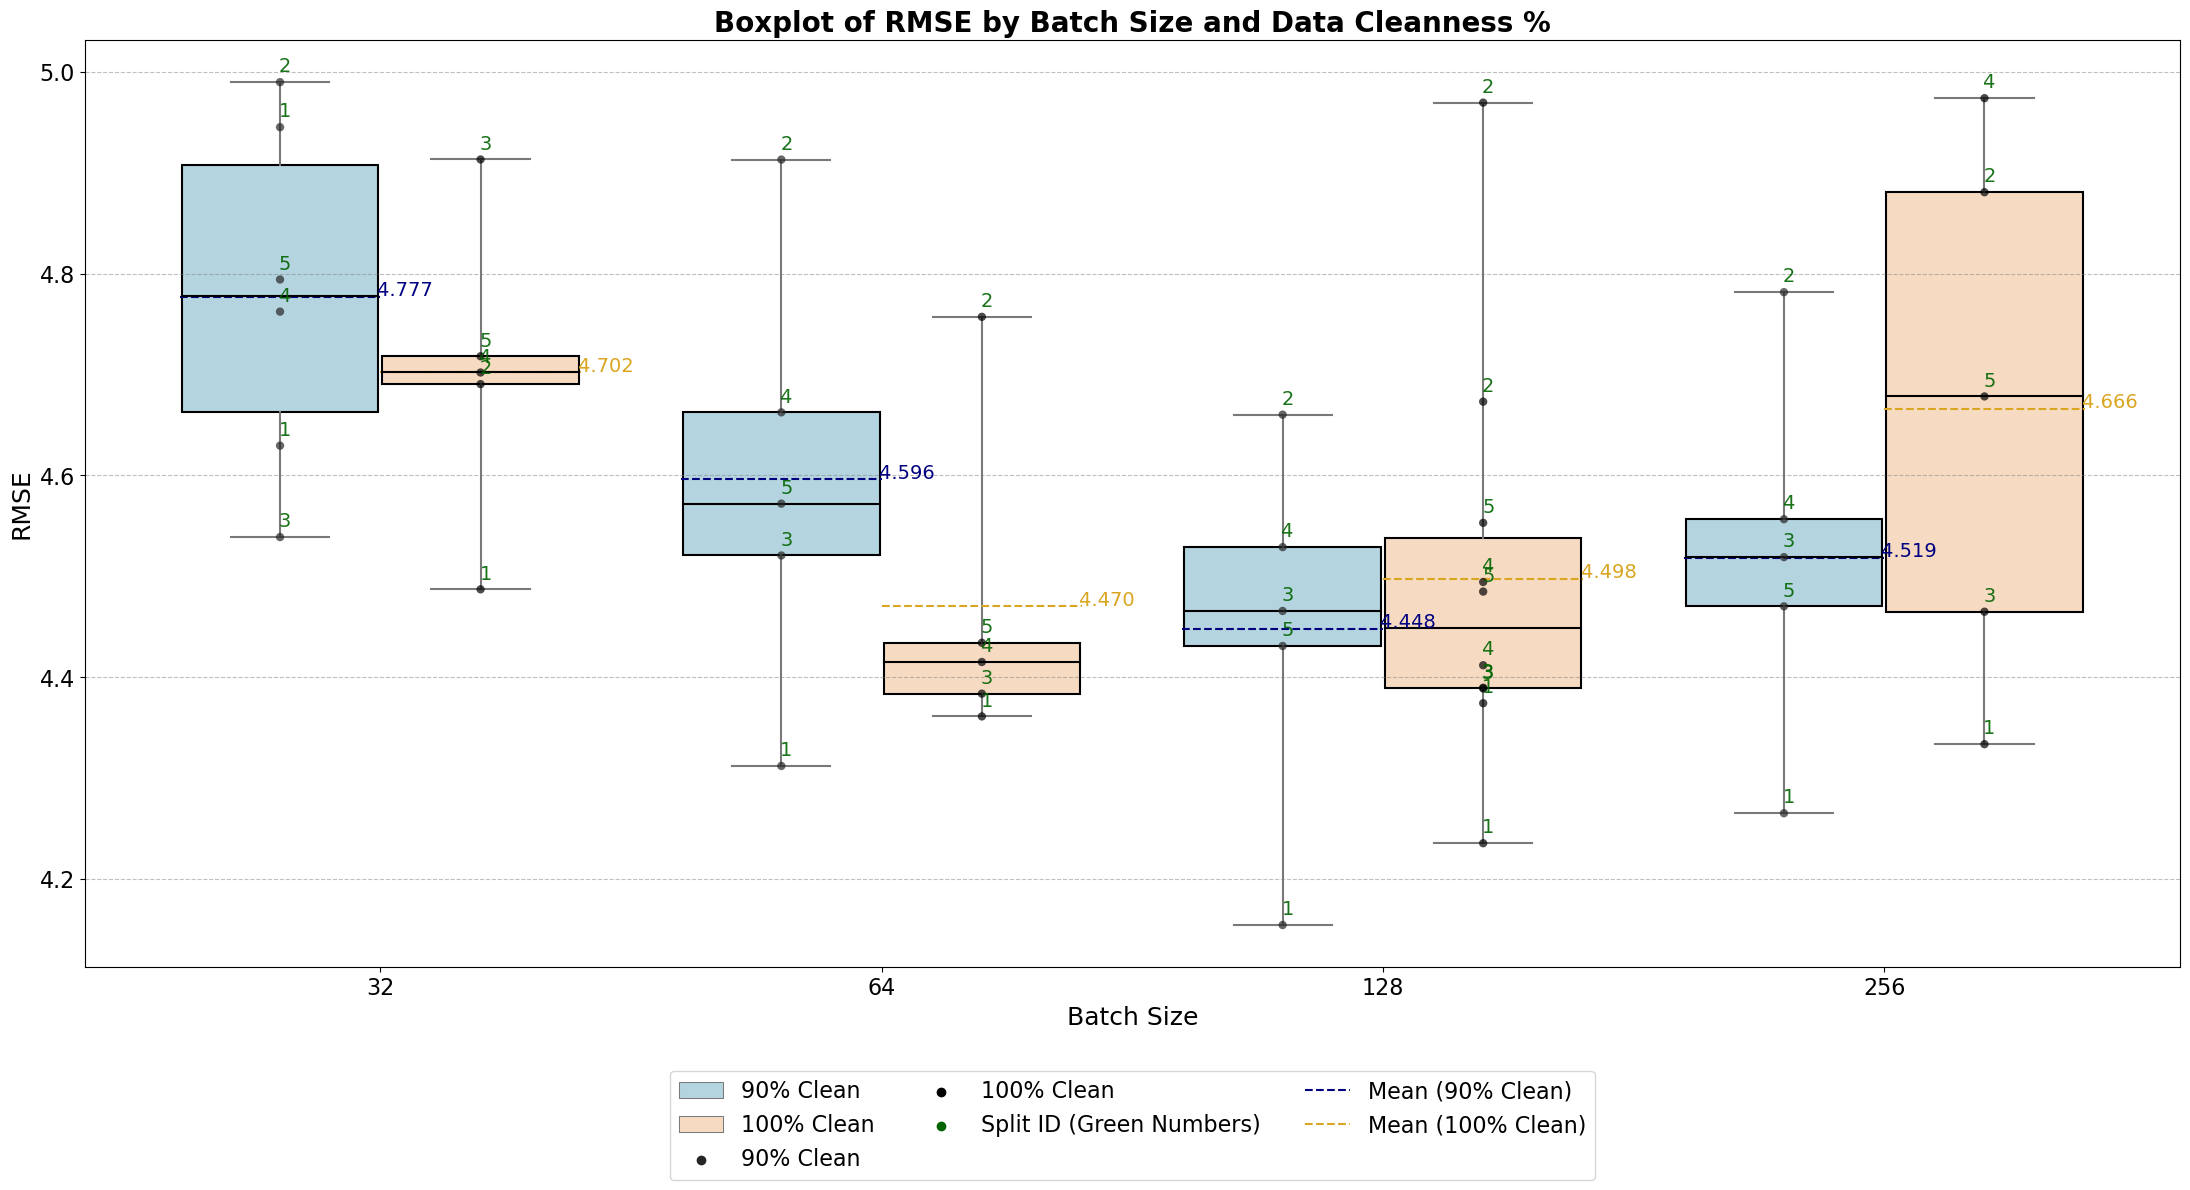

In [150]:
filtered_data_2 = filtered_data_2.copy()
filtered_data = filtered_data.copy()


filtered_data_2['Dataset'] = '100% Clean'
filtered_data['Dataset'] = '90% Clean'

# Combine the two datasets for plotting
combined_data = pd.concat([filtered_data, filtered_data_2])

# Increasing font sizes for all text elements by 4
plt.figure(figsize=(22, 12))

# Create the boxplot with lighter colors for comparison
sns.boxplot(
    x='Batch size', y='RMSE', hue='Dataset', data=combined_data, whis=[0, 100],
    palette={"90% Clean": "#ADD8E6", "100% Clean": "#FFDAB9"},  # Light blue and light orange
    boxprops={"edgecolor": "black"}, medianprops={"color": "black", "linewidth": 1.5}
)

# Overlay individual points for both datasets
sns.stripplot(
    x='Batch size', y='RMSE', hue='Dataset', data=combined_data, jitter=False,
    dodge=True, color='black', alpha=0.7, size=6
)

# Annotate split numbers and calculate means for both datasets
for dataset in combined_data['Dataset'].unique():
    dataset_data = combined_data[combined_data['Dataset'] == dataset]
    offset = -0.2 if dataset == '90% Clean' else 0.2  # Offset to separate datasets
    
    # Annotate split numbers
    for i, row in dataset_data.iterrows():
        x_positions = sorted(combined_data['Batch size'].unique())
        x_pos = x_positions.index(row['Batch size']) + offset
        plt.text(
            x=x_pos + 0.01, y=row['RMSE'] + 0.01, s=f"{row['Split_id']}",  # Annotate split ID
            fontsize=14, color="darkgreen", alpha=0.9, ha='center'  # Increased fontsize
        )
    
    # Plot means with dashed lines
    means = dataset_data.groupby('Batch size')['RMSE'].mean()
    for batch_size, mean in means.items():
        x_positions = sorted(combined_data['Batch size'].unique())
        x_pos = x_positions.index(batch_size) + offset
        plt.plot(
            [x_pos - 0.2, x_pos + 0.2],  # Match the boxplot width
            [mean, mean], color="navy" if dataset == '90% Clean' else "goldenrod", 
            linestyle="--", linewidth=1.5, label=None
        )
        plt.text(
            x=x_pos + 0.25, y=mean + 0.001, s=f"{mean:.3f}",  # Annotate mean
            fontsize=14, color="navy" if dataset == '90% Clean' else "goldenrod", ha='center'  # Increased fontsize
        )

# Adding a refined legend
plt.scatter([], [], color="darkgreen", label="Split ID (Green Numbers)")
plt.plot([], [], color="navy", linestyle="--", label="Mean (90% Clean)")
plt.plot([], [], color="goldenrod", linestyle="--", label="Mean (100% Clean)")
#plt.legend(loc="upper right", fontsize=14)  # Increased fontsize
plt.legend(
    loc='upper center',  
    bbox_to_anchor=(0.5, -0.1), 
    fontsize=16,  
    ncol=3 
)

# Adding titles and labels
plt.title("Boxplot of RMSE by Batch Size and Data Cleanness %", fontsize=20, color="black",fontweight="bold")  # Increased fontsize
plt.xlabel("Batch Size", fontsize=18, color="black")  # Increased fontsize
plt.ylabel("RMSE", fontsize=18, color="black")  # Increased fontsize

# Adjusting tick font sizes and colors
plt.xticks(fontsize=16, color="black")  # Increased fontsize
plt.yticks(fontsize=16, color="black")  # Increased fontsize

# Grid and layout adjustments
plt.grid(axis='y', linestyle='--', alpha=0.5, color="gray")
plt.tight_layout()
plt.savefig('../plots/bs_vs_cleannes.png')
plt.show()


## Batch size vs Resolution Experimentation

Clean experiments for analysis

In [151]:
final_df = pd.DataFrame()  
for r in simple_cnn.Resolution.unique():
    for bs in simple_cnn['Batch size'].unique():
        
        filtered_df = simple_cnn[~simple_cnn['Epochs'].str.split().str[-1].eq('30')] 
        filtered_df = filtered_df[filtered_df['nº samples'] == '784 images'] 
        new_df = filtered_df[
            (filtered_df.Resolution == r) &
            (filtered_df['Batch size'] == bs) &
            (filtered_df.Optimizer == 'Adam') &
            (filtered_df.Loss == 'RMSE') &
            (filtered_df.Variables == 'lst')
        ]

        final_df = pd.concat([final_df, new_df], ignore_index=True)


In [152]:
final_df

,Experiment,RMSE,Variables,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
0,21,4.690602,lst,2,Adam,784 images,32,122 of 300,2024-12-02,15:07:54,310.83,RMSE,64,LST
1,21,4.913294,lst,3,Adam,784 images,32,94 of 300,2024-12-02,15:11:53,238.39,RMSE,64,LST
2,21,4.702104,lst,4,Adam,784 images,32,101 of 300,2024-12-02,15:16:10,256.95,RMSE,64,LST
3,21,4.718179,lst,5,Adam,784 images,32,109 of 300,2024-12-02,15:20:47,277.09,RMSE,64,LST
4,186,4.487147,lst,1,Adam,784 images,32,107 of 300,2024-12-12,14:27:11,295.17,RMSE,64,LST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,126,4.762391,lst,1,Adam,784 images,256,104 of 300,2024-12-11,19:16:44,141.76,RMSE,32,LST
61,126,4.857540,lst,2,Adam,784 images,256,300 of 300,2024-12-11,19:24:09,445.26,RMSE,32,LST
62,126,4.681830,lst,3,Adam,784 images,256,184 of 300,2024-12-11,19:28:29,258.83,RMSE,32,LST
63,126,4.974126,lst,4,Adam,784 images,256,82 of 300,2024-12-11,19:30:19,110.39,RMSE,32,LST


In [153]:
mean_rmse = final_df.groupby(grouping_columns)['RMSE'].mean().reset_index()

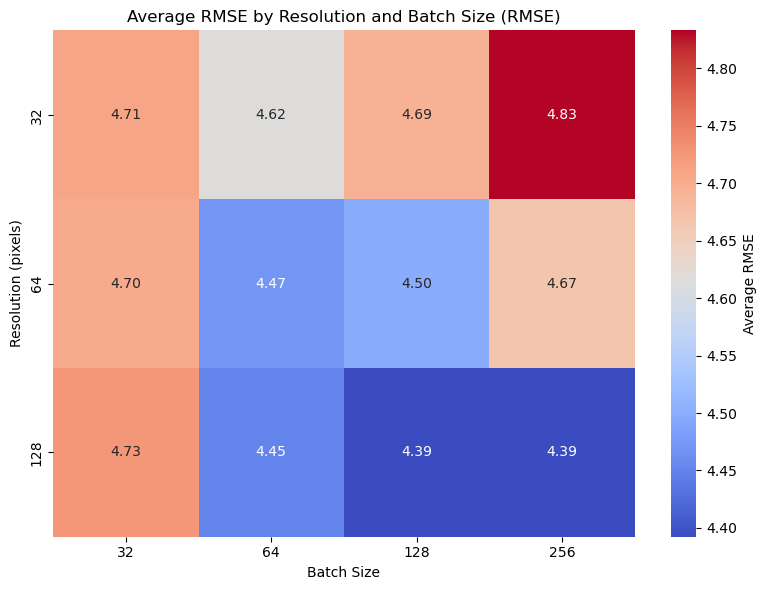

In [154]:
agg_rmse = mean_rmse[mean_rmse["Loss"] == "RMSE"].groupby(["Resolution", "Batch size"], as_index=False)["RMSE"].mean()
physics_mean_rmse = agg_rmse.pivot(
    index="Resolution", columns="Batch size", values="RMSE"
)

plt.figure(figsize=(8, 6))
sns.heatmap(physics_mean_rmse, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Average RMSE'})
plt.title("Average RMSE by Resolution and Batch Size (RMSE)")
plt.xlabel("Batch Size")
plt.ylabel("Resolution (pixels)")
plt.tight_layout()
plt.savefig('../plots/res_vs_bs.png')
plt.show()


/var/folders/lx/01q73krn1md9zqcwvy3rqlqh0000gn/T/ipykernel_6958/1711701473.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


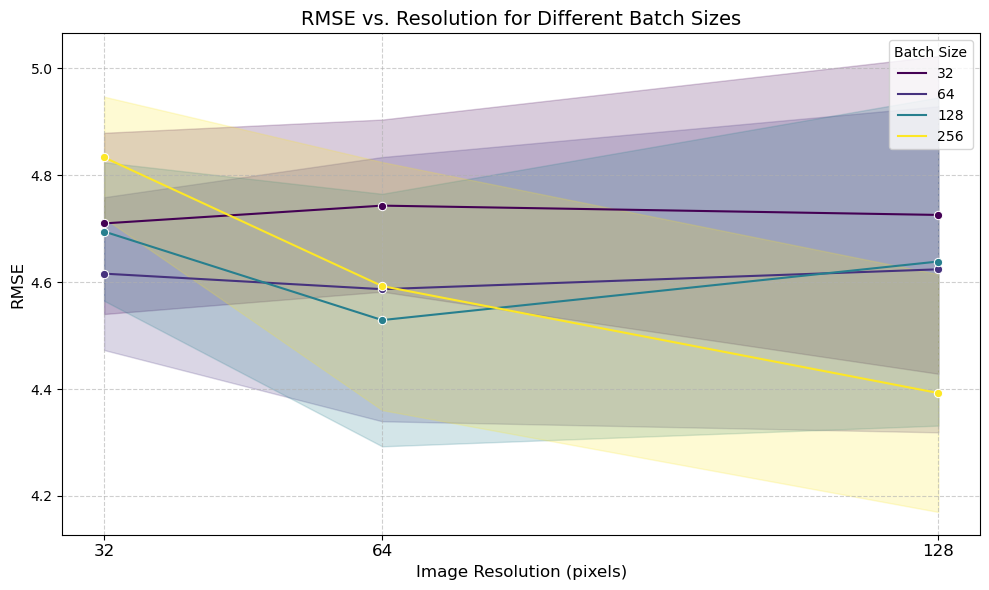

In [155]:
df_lst = simple_cnn[simple_cnn.Variables == 'lst']

# Gráfico de líneas con sombreado para los splits
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_lst, x="Resolution", y="RMSE", hue="Batch size",
    marker="o", palette="viridis", ci="sd"  # 'ci="sd"' añade el área sombreada con desviación estándar
)

resolutions_used = sorted(df_lst["Resolution"].unique())  # Obtener resoluciones únicas para este Split_id
plt.xticks(resolutions_used, labels=[str(res) for res in resolutions_used], fontsize=12)

plt.title("RMSE vs. Resolution for Different Batch Sizes", fontsize=14)
plt.xlabel("Image Resolution (pixels)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.legend(title="Batch Size", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## Optimizers experimentation

Filter by 64 resolution + best combinations

In [156]:
filtered_data = simple_cnn[
            (simple_cnn.Resolution == 64) &
            (simple_cnn['Batch size'].isin([64,128])) &
            (simple_cnn.Optimizer == 'Adam') &
            (simple_cnn.Loss == 'RMSE') &
            (simple_cnn['nº samples'] == '784 images')
            ]
filtered_data_2 = simple_cnn[
            (simple_cnn.Resolution == 64) &
            (simple_cnn['Batch size'].isin([64,128])) &
            (simple_cnn.Optimizer == 'SGD') &
            (simple_cnn.Loss == 'RMSE') &
            (simple_cnn['nº samples'] == '784 images')
            ]

/Users/ruthparajo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


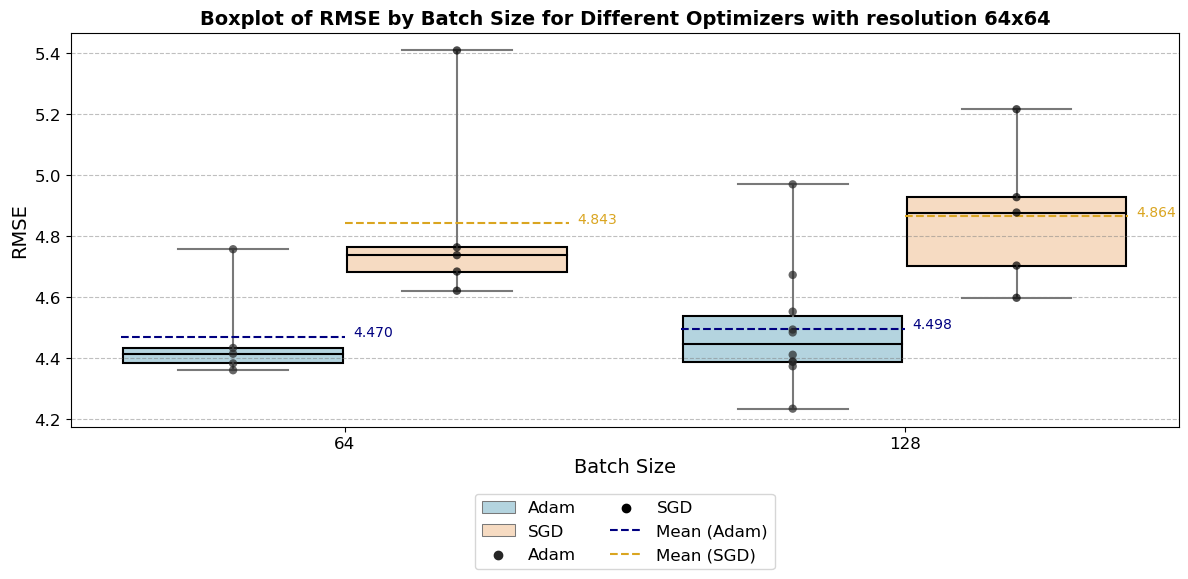

In [157]:
filtered_data_2 = filtered_data_2.copy()
filtered_data = filtered_data.copy()

# Añadir columna para identificar el optimizador
filtered_data_2['Optimizer'] = 'SGD'
filtered_data['Optimizer'] = 'Adam'

# Añadir columna de Split ID si aún no existe
if 'Split ID' not in filtered_data.columns:
    filtered_data['Split ID'] = range(len(filtered_data))
if 'Split ID' not in filtered_data_2.columns:
    filtered_data_2['Split ID'] = range(len(filtered_data_2))

# Combinar los dos conjuntos de datos para graficar
combined_data = pd.concat([filtered_data, filtered_data_2])

# Crear el gráfico con tamaño ajustado
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Crear el gráfico con tamaño ajustado
plt.figure(figsize=(12, 6), dpi=100)

# Gráfico de caja
boxplot = sns.boxplot(
    x='Batch size', y='RMSE', hue='Optimizer', data=combined_data, whis=[0, 100],
    palette={"Adam": "#ADD8E6", "SGD": "#FFDAB9"},
    boxprops={"edgecolor": "black"}, medianprops={"color": "black", "linewidth": 1.5}
)

# Overlay de puntos individuales
sns.stripplot(
    x='Batch size', y='RMSE', hue='Optimizer', data=combined_data, jitter=False,
    dodge=True, color='black', alpha=0.7, size=6
)

# Añadir líneas discontinuas para la media por grupo
for optimizer in combined_data['Optimizer'].unique():  # Iterar por cada optimizador (Adam, SGD)
    optimizer_data = combined_data[combined_data['Optimizer'] == optimizer]  # Filtrar datos para el optimizador actual
    offset = -0.2 if optimizer == 'Adam' else 0.2  # Desplazar ligeramente las líneas para separarlas

    # Calcular la media de RMSE por Batch size
    means = optimizer_data.groupby('Batch size')['RMSE'].mean()
    for batch_size, mean in means.items():  # Iterar por cada Batch size
        x_positions = sorted(combined_data['Batch size'].unique())  # Obtener las posiciones únicas en el eje x
        x_pos = x_positions.index(batch_size) + offset  # Ajustar la posición x para el optimizador actual
        
        # Dibujar línea discontinua de la media
        plt.plot(
            [x_pos - 0.2, x_pos + 0.2], 
            [mean, mean], 
            color="navy" if optimizer == 'Adam' else "goldenrod", 
            linestyle="--", linewidth=1.5, label=None
        )
        
        # Anotar el valor de la media en el gráfico
        plt.text(
            x=x_pos + 0.25, y=mean + 0.001, s=f"{mean:.3f}",  
            fontsize=10, color="navy" if optimizer == 'Adam' else "goldenrod", ha='center'
        )

# Refinar la leyenda
plt.plot([], [], color="navy", linestyle="--", label="Mean (Adam)")
plt.plot([], [], color="goldenrod", linestyle="--", label="Mean (SGD)")
plt.legend(
    loc='upper center',  
    bbox_to_anchor=(0.5, -0.15), 
    fontsize=12,  
    ncol=2 
)

# Etiquetas y título
plt.title("Boxplot of RMSE by Batch Size for Different Optimizers with resolution 64x64", fontsize=14, color="black", fontweight="bold")
plt.xlabel("Batch Size", fontsize=14, color="black")
plt.ylabel("RMSE", fontsize=14, color="black")

# Ajustar las etiquetas
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5, color="gray")

plt.tight_layout()  # Ajustar márgenes automáticamente
#plt.savefig('../plots/batchsize_vs_optimizer_means.png')  # Guardar el gráfico
plt.show()  # Mostrar el gráfico


/Users/ruthparajo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


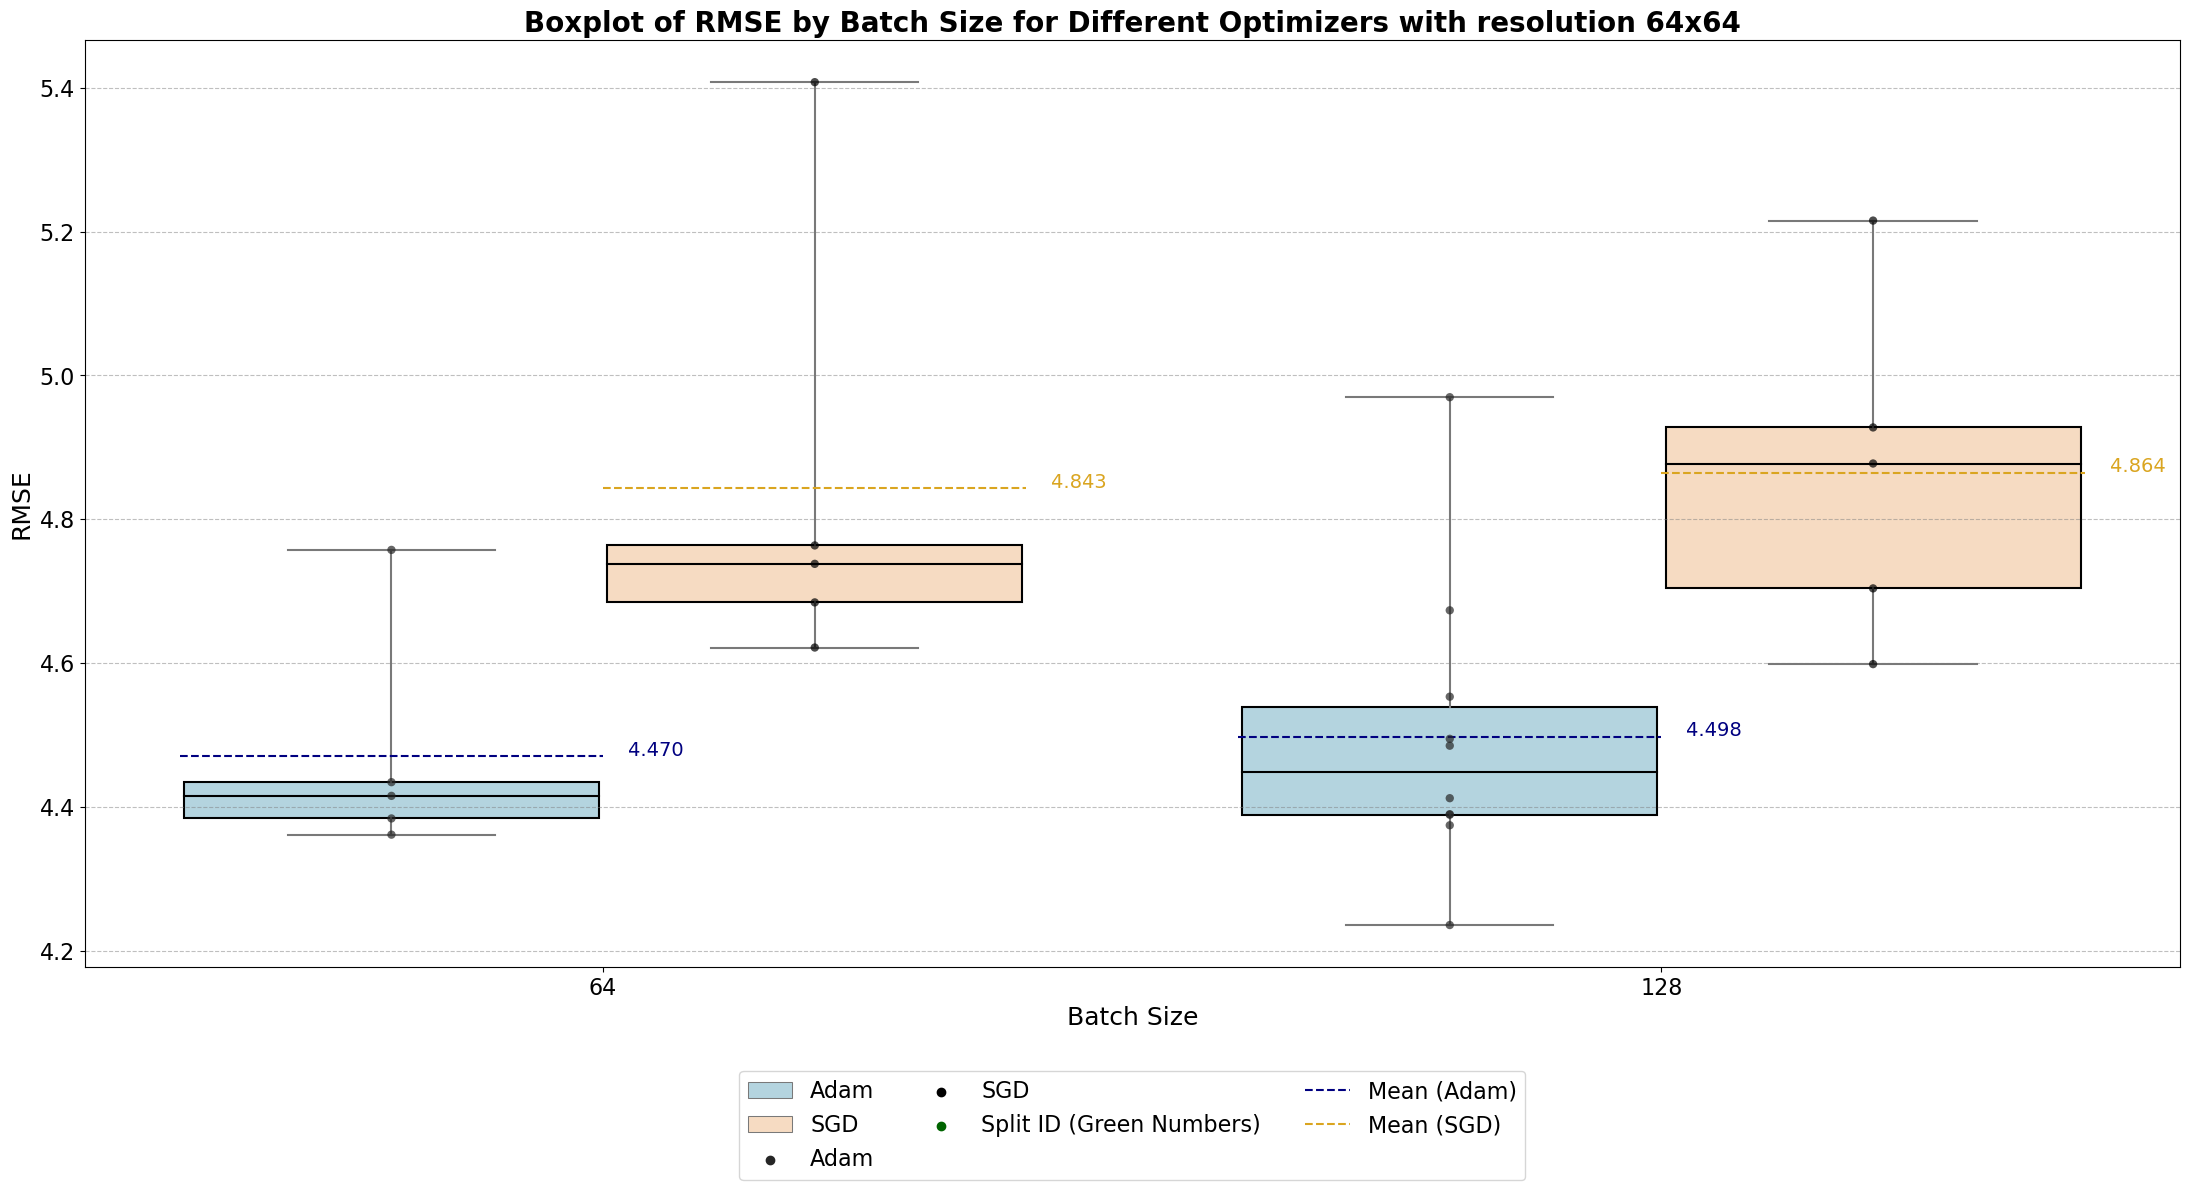

In [158]:
filtered_data_2 = filtered_data_2.copy()
filtered_data = filtered_data.copy()

# Añadir columna para identificar el optimizador
filtered_data_2['Optimizer'] = 'SGD'
filtered_data['Optimizer'] = 'Adam'

# Combinar los dos conjuntos de datos para graficar
combined_data = pd.concat([filtered_data, filtered_data_2])

# Crear el gráfico
plt.figure(figsize=(22, 12))

# Gráfico de caja con los optimizadores
sns.boxplot(
    x='Batch size', y='RMSE', hue='Optimizer', data=combined_data, whis=[0, 100],
    palette={"Adam": "#ADD8E6", "SGD": "#FFDAB9"},  # Light blue and light orange
    boxprops={"edgecolor": "black"}, medianprops={"color": "black", "linewidth": 1.5}
)

# Overlay puntos individuales para cada optimizador
sns.stripplot(
    x='Batch size', y='RMSE', hue='Optimizer', data=combined_data, jitter=False,
    dodge=True, color='black', alpha=0.7, size=6
)

# Calcular y anotar las medias por batch size y optimizador
for optimizer in combined_data['Optimizer'].unique():
    optimizer_data = combined_data[combined_data['Optimizer'] == optimizer]
    offset = -0.2 if optimizer == 'Adam' else 0.2  # Offset para separar optimizadores
    
    
    # Plot de las medias
    means = optimizer_data.groupby('Batch size')['RMSE'].mean()
    for batch_size, mean in means.items():
        x_positions = sorted(combined_data['Batch size'].unique())
        x_pos = x_positions.index(batch_size) + offset
        plt.plot(
            [x_pos - 0.2, x_pos + 0.2],  # Match the boxplot width
            [mean, mean], color="navy" if optimizer == 'Adam' else "goldenrod", 
            linestyle="--", linewidth=1.5, label=None
        )
        plt.text(
            x=x_pos + 0.25, y=mean + 0.001, s=f"{mean:.3f}",  # Anotar la media
            fontsize=14, color="navy" if optimizer == 'Adam' else "goldenrod", ha='center'
        )

# Refinar la leyenda
plt.scatter([], [], color="darkgreen", label="Split ID (Green Numbers)")
plt.plot([], [], color="navy", linestyle="--", label="Mean (Adam)")
plt.plot([], [], color="goldenrod", linestyle="--", label="Mean (SGD)")
plt.legend(
    loc='upper center',  
    bbox_to_anchor=(0.5, -0.1), 
    fontsize=16,  
    ncol=3 
)

# Etiquetas y título
plt.title("Boxplot of RMSE by Batch Size for Different Optimizers with resolution 64x64", fontsize=20, color="black", fontweight="bold")
plt.xlabel("Batch Size", fontsize=18, color="black")
plt.ylabel("RMSE", fontsize=18, color="black")

# Ajuste de ticks y cuadrícula
plt.xticks(fontsize=16, color="black")
plt.yticks(fontsize=16, color="black")
plt.grid(axis='y', linestyle='--', alpha=0.5, color="gray")

plt.tight_layout()
#plt.savefig('../plots/batchsize_vs_optimizer64.png')
plt.show()


Filter by 128 resolution + best combinations

In [159]:
filtered_data = simple_cnn[
            (simple_cnn.Resolution == 128) &
            (simple_cnn['Batch size'].isin([64,128])) &
            (simple_cnn.Optimizer == 'Adam') &
            (simple_cnn.Loss == 'RMSE') &
            (simple_cnn['nº samples'] == '784 images') &
            (simple_cnn.Variables == 'lst')
            ]
filtered_data_2 = simple_cnn[
            (simple_cnn.Resolution == 128) &
            (simple_cnn['Batch size'].isin([64,128])) &
            (simple_cnn.Optimizer == 'SGD') &
            (simple_cnn.Loss == 'RMSE') &
            (simple_cnn['nº samples'] == '784 images')&
            (simple_cnn.Variables == 'lst')
            ]

/Users/ruthparajo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


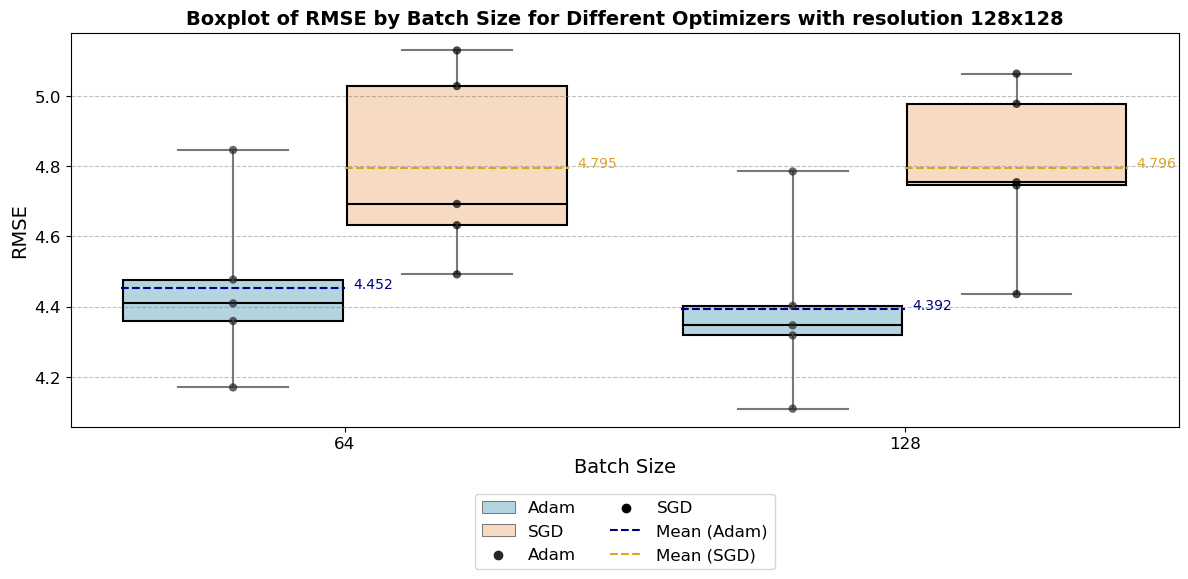

In [160]:
filtered_data_2 = filtered_data_2.copy()
filtered_data = filtered_data.copy()

# Añadir columna para identificar el optimizador
filtered_data_2['Optimizer'] = 'SGD'
filtered_data['Optimizer'] = 'Adam'

# Combinar los dos conjuntos de datos para graficar
combined_data = pd.concat([filtered_data, filtered_data_2])

#Crear el gráfico con tamaño ajustado
plt.figure(figsize=(12, 6), dpi=100)

# Gráfico de caja
boxplot = sns.boxplot(
    x='Batch size', y='RMSE', hue='Optimizer', data=combined_data, whis=[0, 100],
    palette={"Adam": "#ADD8E6", "SGD": "#FFDAB9"},
    boxprops={"edgecolor": "black"}, medianprops={"color": "black", "linewidth": 1.5}
)

# Overlay de puntos individuales
sns.stripplot(
    x='Batch size', y='RMSE', hue='Optimizer', data=combined_data, jitter=False,
    dodge=True, color='black', alpha=0.7, size=6
)

# Añadir líneas discontinuas para la media por grupo
for optimizer in combined_data['Optimizer'].unique():  # Iterar por cada optimizador (Adam, SGD)
    optimizer_data = combined_data[combined_data['Optimizer'] == optimizer]  # Filtrar datos para el optimizador actual
    offset = -0.2 if optimizer == 'Adam' else 0.2  # Desplazar ligeramente las líneas para separarlas

    # Calcular la media de RMSE por Batch size
    means = optimizer_data.groupby('Batch size')['RMSE'].mean()
    for batch_size, mean in means.items():  # Iterar por cada Batch size
        x_positions = sorted(combined_data['Batch size'].unique())  # Obtener las posiciones únicas en el eje x
        x_pos = x_positions.index(batch_size) + offset  # Ajustar la posición x para el optimizador actual
        
        # Dibujar línea discontinua de la media
        plt.plot(
            [x_pos - 0.2, x_pos + 0.2], 
            [mean, mean], 
            color="navy" if optimizer == 'Adam' else "goldenrod", 
            linestyle="--", linewidth=1.5, label=None
        )
        
        # Anotar el valor de la media en el gráfico
        plt.text(
            x=x_pos + 0.25, y=mean + 0.001, s=f"{mean:.3f}",  
            fontsize=10, color="navy" if optimizer == 'Adam' else "goldenrod", ha='center'
        )

# Refinar la leyenda
plt.plot([], [], color="navy", linestyle="--", label="Mean (Adam)")
plt.plot([], [], color="goldenrod", linestyle="--", label="Mean (SGD)")
plt.legend(
    loc='upper center',  
    bbox_to_anchor=(0.5, -0.15), 
    fontsize=12,  
    ncol=2 
)

# Etiquetas y título
plt.title("Boxplot of RMSE by Batch Size for Different Optimizers with resolution 128x128", fontsize=14, color="black", fontweight="bold")
plt.xlabel("Batch Size", fontsize=14, color="black")
plt.ylabel("RMSE", fontsize=14, color="black")

# Ajustar las etiquetas
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5, color="gray")

plt.tight_layout()
#plt.savefig('../plots/batchsize_vs_optimizer128.png')
plt.show()


# Data augmentation

In [161]:
simple_cnn['nº samples'].unique()

array(['826 images', '784 images', '1568 images + 50176 augmented',
       '1081 images', '1405 images', '1059 images', '1359 images',
       '1026 images', '1290 images', '982 images', '1198 images',
       '1729 images', '1659 images', '1554 images', '1414 images',
       '4866 images, all augmented', '4854 images, all augmented',
       '4836 images, all augmented', '4812 images, all augmented',
       '24330 images, all augmented 5x', '24270 images, all augmented 5x',
       '24180 images, all augmented 5x', '24060 images, all augmented 5x'],
      dtype=object)

In [162]:
aug_1 = ['1081 images', '1059 images', '1026 images', '982 images']
aug_2 = ['1405 images', '1359 images', '1290 images', '1198 images']
aug_3 = ['1729 images', '1659 images', '1554 images', '1414 images']

## Outlier ratio augmentation 

In [163]:
filtered_data_0 = simple_cnn[
    (simple_cnn.Resolution == 128) &
    (simple_cnn['Batch size'] == 128) &
    (simple_cnn.Optimizer == 'Adam') &
    (simple_cnn['nº samples']== '784 images') &
    (simple_cnn['Normalized Variables'] == 'LST') &
    (simple_cnn.Loss == 'RMSE')
]
filtered_data_0

,Experiment,RMSE,Variables,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
90,126,4.109246,lst,1,Adam,784 images,128,75 of 300,2024-12-11,18:14:40,130.26,RMSE,128,LST
91,126,4.785328,lst,2,Adam,784 images,128,63 of 300,2024-12-11,18:16:31,110.07,RMSE,128,LST
93,126,4.346643,lst,3,Adam,784 images,128,77 of 300,2024-12-11,18:18:45,132.68,RMSE,128,LST
94,126,4.318129,lst,4,Adam,784 images,128,148 of 300,2024-12-11,18:23:07,261.06,RMSE,128,LST
96,126,4.402462,lst,5,Adam,784 images,128,134 of 300,2024-12-11,18:27:04,235.67,RMSE,128,LST


In [164]:
filtered_data_0 = simple_cnn[
    (simple_cnn.Resolution == 128) &
    (simple_cnn['Batch size'] == 128) &
    (simple_cnn.Optimizer == 'Adam') &
    (simple_cnn['nº samples']== '784 images') &
    (simple_cnn['Normalized Variables'] == 'LST') &
    (simple_cnn.Loss == 'RMSE')
]

filtered_data = simple_cnn[
    (simple_cnn.Resolution == 128) &
    (simple_cnn['Batch size'] == 128) &
    (simple_cnn.Optimizer == 'Adam') &
    (simple_cnn['nº samples'].isin(aug_1)) &
    (simple_cnn['Normalized Variables'] == 'LST')
]

filtered_data_2 = simple_cnn[
    (simple_cnn.Resolution == 128) &
    (simple_cnn['Batch size'] == 128) &
    (simple_cnn.Optimizer == 'Adam') &
    (simple_cnn['nº samples'].isin(aug_2)) &
    (simple_cnn['Normalized Variables'] == 'LST')
]

filtered_data_3 = simple_cnn[
    (simple_cnn.Resolution == 128) &
    (simple_cnn['Batch size'] == 128) &
    (simple_cnn.Optimizer == 'Adam') &
    (simple_cnn['nº samples'].isin(aug_3)) &
    (simple_cnn['Normalized Variables'] == 'LST')
]

filtered_data

,Experiment,RMSE,Variables,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
167,168,4.540688,lst,1,Adam,1081 images,128,59 of 300,2024-12-19,11:13:04,143.05,RMSE,128,LST
169,168,4.708490,lst,2,Adam,1059 images,128,58 of 300,2024-12-19,11:15:22,137.07,RMSE,128,LST
171,168,4.585446,lst,3,Adam,1081 images,128,60 of 300,2024-12-19,11:17:52,145.47,RMSE,128,LST
173,168,4.571830,lst,4,Adam,1026 images,128,85 of 300,2024-12-19,11:21:14,197.68,RMSE,128,LST
175,168,4.627966,lst,5,Adam,982 images,128,66 of 300,2024-12-19,11:23:43,144.80,RMSE,128,LST


In [165]:
for bs in filtered_data['Batch size'].unique():
    print(validate_dataframe(filtered_data[filtered_data['Batch size']==bs]))
    if not validate_dataframe(filtered_data[filtered_data['Batch size']==bs]):
        print(filtered_data[filtered_data['Batch size']==bs])
        
    print(validate_dataframe(filtered_data_2[filtered_data_2['Batch size']==bs]))
    if not validate_dataframe(filtered_data_2[filtered_data_2['Batch size']==bs]):
        print(filtered_data_2[filtered_data_2['Batch size']==bs])

    print(validate_dataframe(filtered_data_3[filtered_data_3['Batch size']==bs]))
    if not validate_dataframe(filtered_data_3[filtered_data_3['Batch size']==bs]):
        print(filtered_data_2[filtered_data_3['Batch size']==bs])


True
True
True


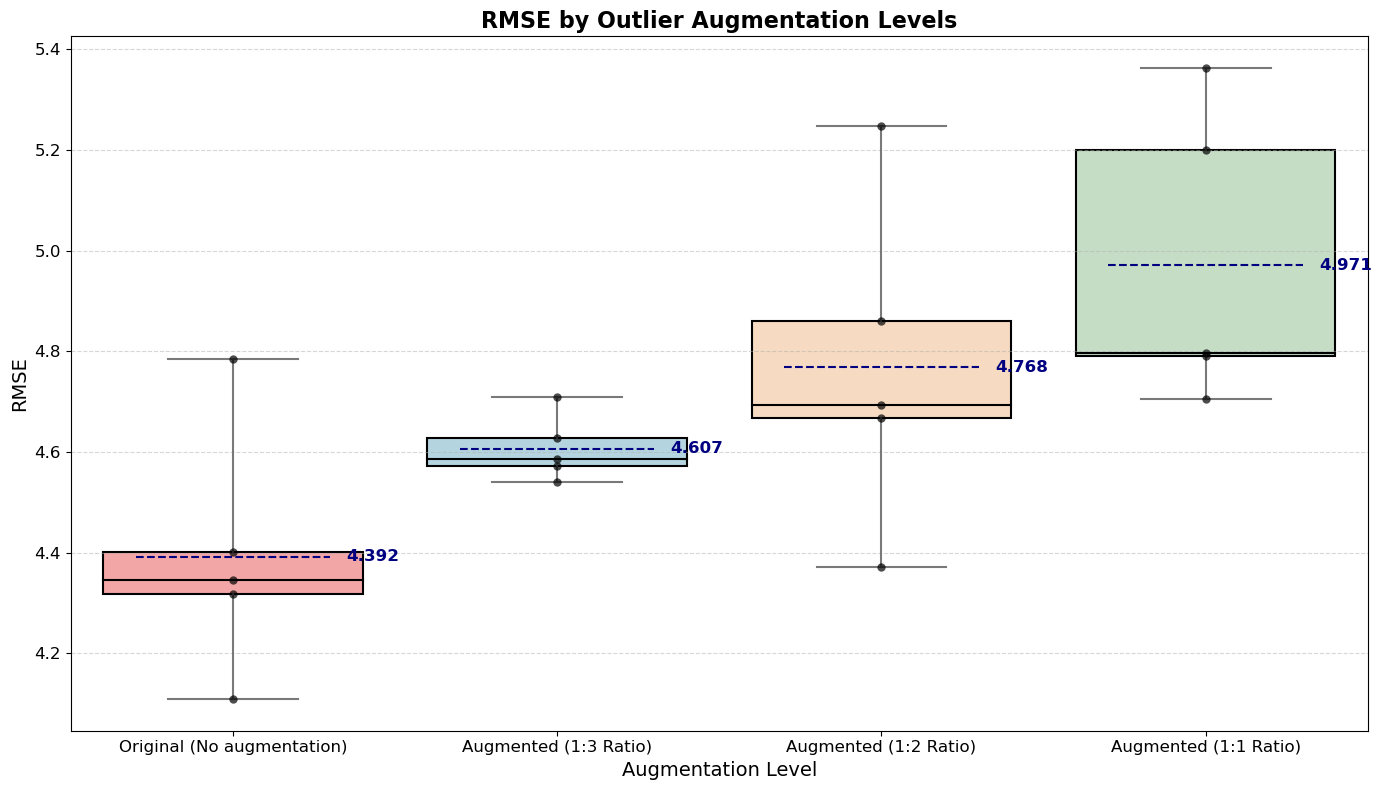

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example filtered datasets (replace these with your actual datasets)
filtered_data_0 = filtered_data_0.copy()
filtered_data = filtered_data.copy()
filtered_data_2 = filtered_data_2.copy()
filtered_data_3 = filtered_data_3.copy()

# Add labels for augmentation levels
filtered_data_0['Augmentation Level'] = "Original (No augmentation)"#'No Augmentation'
filtered_data['Augmentation Level'] = "Augmented (1:3 Ratio)"#'1x Augmented'
filtered_data_2['Augmentation Level'] = "Augmented (1:2 Ratio)"#'2x Augmented'
filtered_data_3['Augmentation Level'] = "Augmented (1:1 Ratio)"#'3x Augmented'

# Combine datasets
combined_data = pd.concat([filtered_data_0, filtered_data, filtered_data_2, filtered_data_3])

# Create the boxplot
plt.figure(figsize=(14, 8))

sns.boxplot(
    x='Augmentation Level', y='RMSE', data=combined_data, whis=[0, 100],
    palette={"Original (No augmentation)": "#FF9999",  # Light red
             "Augmented (1:3 Ratio)": "#ADD8E6",     # Light blue
             "Augmented (1:2 Ratio)": "#FFDAB9",    # Light orange
             "Augmented (1:1 Ratio)": "#C1E1C1"},   # Light green
    boxprops={"edgecolor": "black"}, medianprops={"color": "black", "linewidth": 1.5}
)

# Overlay individual points
sns.stripplot(
    x='Augmentation Level', y='RMSE', data=combined_data, jitter=False,
    dodge=True, color='black', alpha=0.7, size=6
)

# Annotate means for each augmentation level
box_width = 0.6  # Width of the boxplot (default in Seaborn is 0.8, adjusted here)
for augmentation_level in combined_data['Augmentation Level'].unique():
    data_level = combined_data[combined_data['Augmentation Level'] == augmentation_level]
    mean_rmse = data_level['RMSE'].mean()
    
    x_pos = combined_data['Augmentation Level'].unique().tolist().index(augmentation_level)
    plt.plot(
        [x_pos - box_width / 2, x_pos + box_width / 2],  # Match the boxplot width
        [mean_rmse, mean_rmse], 
        color="navy", linestyle="--", linewidth=1.5, label=None
    )
    plt.text(
        x=x_pos + box_width / 2 + 0.05, y=mean_rmse, s=f"{mean_rmse:.3f}",  # Place next to the line
        fontsize=12, color="navy", fontweight="bold", va='center'
    )

# Add legend and labels
plt.legend([], [], frameon=False)  # No legend for augmentation
plt.title("RMSE by Outlier Augmentation Levels", fontsize=16, fontweight="bold")
plt.xlabel("Augmentation Level", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Save and show the plot
plt.tight_layout()
plt.savefig('../plots/outlier_augmentation.png')
plt.show()


## Overall augmentation

In [167]:
filtered_data_0 = simple_cnn[
    (simple_cnn.Resolution == 128) &
    (simple_cnn['Batch size'] == 128) &
    (simple_cnn.Optimizer == 'Adam') &
    (simple_cnn['nº samples']== '784 images') &
    (simple_cnn['Normalized Variables'] == 'LST') &
    (simple_cnn.Loss == 'RMSE')
]

filtered_data = simple_cnn[
    (simple_cnn.Resolution == 128) &
    (simple_cnn['Batch size'] == 128) &
    (simple_cnn.Optimizer == 'Adam') &
    (simple_cnn['nº samples'].str.endswith('all augmented')) &
    (simple_cnn['Normalized Variables'] == 'LST')
]

filtered_data_2 = simple_cnn[
    (simple_cnn.Resolution == 128) &
    (simple_cnn['Batch size'] == 128) &
    (simple_cnn.Optimizer == 'Adam') &
    (simple_cnn['nº samples'].str.endswith('all augmented 2x')) &
    (simple_cnn['Normalized Variables'] == 'LST')
]

filtered_data_3 = simple_cnn[
    (simple_cnn.Resolution == 128) &
    (simple_cnn['Batch size'] == 128) &
    (simple_cnn.Optimizer == 'Adam') &
    (simple_cnn['nº samples'].str.endswith('all augmented 5x')) &
    (simple_cnn['Normalized Variables'] == 'LST')
]

filtered_data

,Experiment,RMSE,Variables,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
182,183,4.210135,lst,1,Adam,"4866 images, all augmented",128,56 of 300,2024-12-19,13:56:01,507.44,RMSE,128,LST
183,183,4.576049,lst,2,Adam,"4854 images, all augmented",128,43 of 300,2024-12-19,14:02:36,383.52,RMSE,128,LST
184,183,4.495413,lst,3,Adam,"4866 images, all augmented",128,50 of 300,2024-12-19,14:10:16,451.03,RMSE,128,LST
185,183,4.306352,lst,4,Adam,"4836 images, all augmented",128,46 of 300,2024-12-19,14:17:15,412.40,RMSE,128,LST
186,183,4.541492,lst,5,Adam,"4812 images, all augmented",128,52 of 300,2024-12-19,14:25:10,468.29,RMSE,128,LST


In [168]:
filtered_data_3

,Experiment,RMSE,Variables,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
187,188,4.834912,lst,1,Adam,"24330 images, all augmented 5x",128,37 of 300,2024-12-19,15:24:34,1607.71,RMSE,128,LST
188,188,5.301043,lst,2,Adam,"24270 images, all augmented 5x",128,35 of 300,2024-12-19,15:50:07,1510.91,RMSE,128,LST
189,188,4.877460,lst,3,Adam,"24330 images, all augmented 5x",128,40 of 300,2024-12-19,16:19:24,1733.85,RMSE,128,LST
190,188,5.182342,lst,4,Adam,"24180 images, all augmented 5x",128,41 of 300,2024-12-19,16:49:29,1780.49,RMSE,128,LST
191,188,4.873706,lst,5,Adam,"24060 images, all augmented 5x",128,42 of 300,2024-12-19,17:19:56,1803.87,RMSE,128,LST


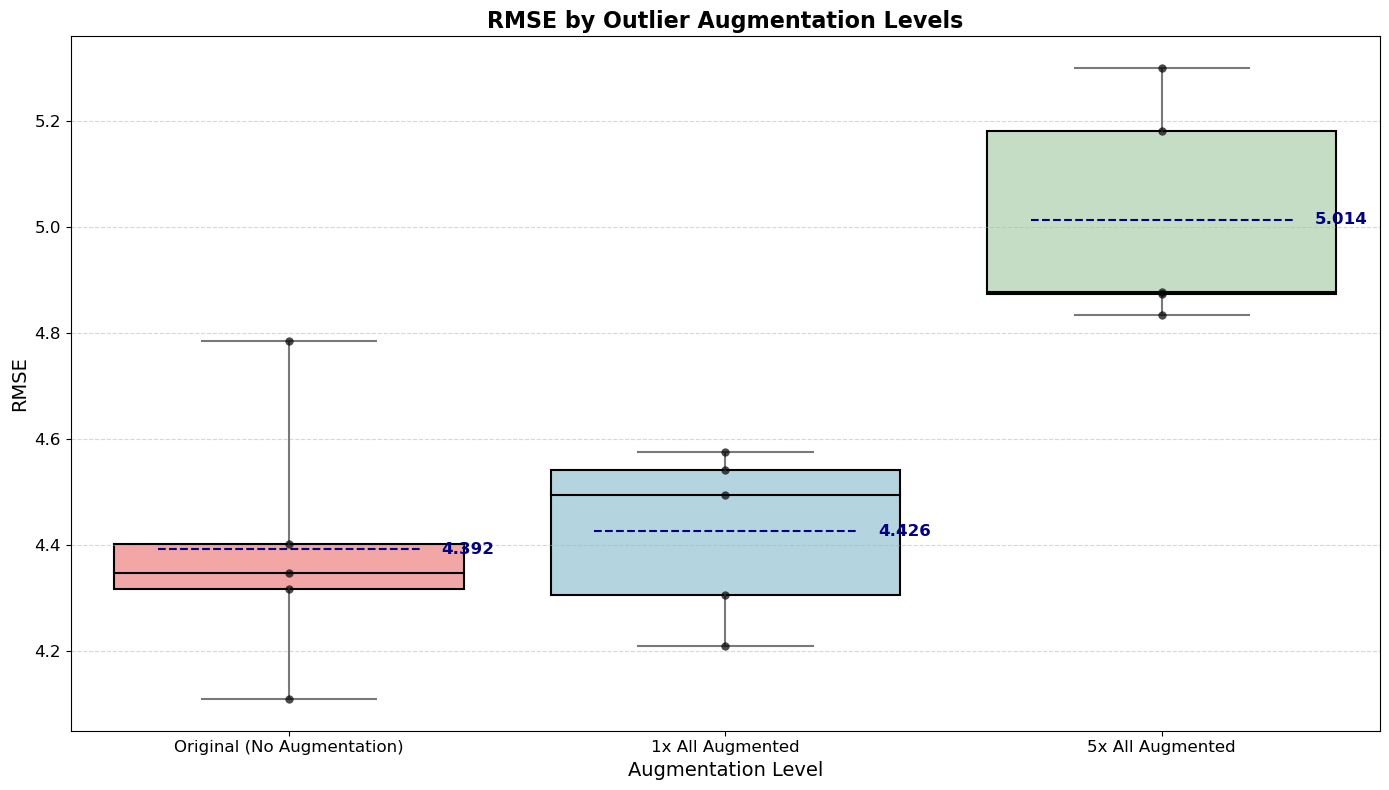

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example filtered datasets (replace these with your actual datasets)
filtered_data_0 = filtered_data_0.copy()
filtered_data = filtered_data.copy()
filtered_data_2 = filtered_data_2.copy()
filtered_data_3 = filtered_data_3.copy()

# Add labels for augmentation levels
filtered_data_0['Augmentation Level'] = 'Original (No Augmentation)'
filtered_data['Augmentation Level'] = '1x All Augmented'
filtered_data_2['Augmentation Level'] = '2x All Augmented'
filtered_data_3['Augmentation Level'] = '5x All Augmented'

# Combine datasets
combined_data = pd.concat([filtered_data_0, filtered_data, filtered_data_2, filtered_data_3])

# Create the boxplot
plt.figure(figsize=(14, 8))

sns.boxplot(
    x='Augmentation Level', y='RMSE', data=combined_data, whis=[0, 100],
    palette={'Original (No Augmentation)': "#FF9999",  # Light red
             '1x All Augmented': "#ADD8E6",     # Light blue
             '2x All Augmented': "#FFDAB9",    # Light orange
             '5x All Augmented': "#C1E1C1"},   # Light green
    boxprops={"edgecolor": "black"}, medianprops={"color": "black", "linewidth": 1.5}
)

# Overlay individual points
sns.stripplot(
    x='Augmentation Level', y='RMSE', data=combined_data, jitter=False,
    dodge=True, color='black', alpha=0.7, size=6
)

# Annotate means for each augmentation level
box_width = 0.6  # Width of the boxplot (default in Seaborn is 0.8, adjusted here)
for augmentation_level in combined_data['Augmentation Level'].unique():
    data_level = combined_data[combined_data['Augmentation Level'] == augmentation_level]
    mean_rmse = data_level['RMSE'].mean()
    
    x_pos = combined_data['Augmentation Level'].unique().tolist().index(augmentation_level)
    plt.plot(
        [x_pos - box_width / 2, x_pos + box_width / 2],  # Match the boxplot width
        [mean_rmse, mean_rmse], 
        color="navy", linestyle="--", linewidth=1.5, label=None
    )
    plt.text(
        x=x_pos + box_width / 2 + 0.05, y=mean_rmse, s=f"{mean_rmse:.3f}",  # Place next to the line
        fontsize=12, color="navy", fontweight="bold", va='center'
    )

# Add legend and labels
plt.legend([], [], frameon=False)  # No legend for augmentation
plt.title("RMSE by Outlier Augmentation Levels", fontsize=16, fontweight="bold")
plt.xlabel("Augmentation Level", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Save and show the plot
plt.tight_layout()
#plt.savefig('../plots/outlier_augmentation.png')
plt.show()


# Loss experimentation

In [170]:
filtered_data = simple_cnn[
    (simple_cnn.Resolution == 128) &
    (simple_cnn['Batch size'] == 128) &
    (simple_cnn.Optimizer == 'Adam') &
    (simple_cnn['nº samples'] == '784 images') &
    (simple_cnn['Normalized Variables'] == 'LST')
]

filtered_data

,Experiment,RMSE,Variables,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
90,126,4.109246,lst,1,Adam,784 images,128,75 of 300,2024-12-11,18:14:40,130.26,RMSE,128,LST
91,126,4.785328,lst,2,Adam,784 images,128,63 of 300,2024-12-11,18:16:31,110.07,RMSE,128,LST
93,126,4.346643,lst,3,Adam,784 images,128,77 of 300,2024-12-11,18:18:45,132.68,RMSE,128,LST
94,126,4.318129,lst,4,Adam,784 images,128,148 of 300,2024-12-11,18:23:07,261.06,RMSE,128,LST
96,126,4.402462,lst,5,Adam,784 images,128,134 of 300,2024-12-11,18:27:04,235.67,RMSE,128,LST
124,125,4.163678,lst,1,Adam,784 images,128,75 of 300,2024-12-12,16:13:36,152.54,RMSE_sensitive,128,LST
125,125,4.114296,lst,1,Adam,784 images,128,100 of 300,2024-12-12,16:14:06,200.97,RMSE_focal,128,LST
127,125,4.793154,lst,2,Adam,784 images,128,66 of 300,2024-12-12,16:15:48,130.86,RMSE_sensitive,128,LST
128,125,4.730996,lst,2,Adam,784 images,128,70 of 300,2024-12-12,16:16:25,137.96,RMSE_focal,128,LST
129,125,4.432616,lst,3,Adam,784 images,128,56 of 300,2024-12-12,16:18:15,108.71,RMSE_focal,128,LST


In [171]:
# Calculate the standard deviation for each group (Loss)
stds = filtered_data.groupby('Loss')['RMSE'].std()

# Display the results
print("Standard deviation by Loss:")
print(stds)

# Identify the set with the least variation
min_variation_loss = stds.idxmin()
print(f"The set with the least variation is: {min_variation_loss} with a standard deviation of {stds[min_variation_loss]:.3f}")
latex_table = stds.reset_index().rename(columns={'Loss': 'Loss Function', 'RMSE': 'Standard Deviation'}).to_latex(
    index=False, float_format="%.3f", caption="Standard Deviation of RMSE by Loss Function", label="tab:rmse_std"
)
print()
print(latex_table)

Standard deviation by Loss:
Loss
Physics_guided    0.181315
RMSE              0.246109
RMSE_focal        0.219198
RMSE_sensitive    0.238597
Name: RMSE, dtype: float64
The set with the least variation is: Physics_guided with a standard deviation of 0.181

\begin{table}
\caption{Standard Deviation of RMSE by Loss Function}
\label{tab:rmse_std}
\begin{tabular}{lr}
\toprule
Loss Function & Standard Deviation \\
\midrule
Physics_guided & 0.181 \\
RMSE & 0.246 \\
RMSE_focal & 0.219 \\
RMSE_sensitive & 0.239 \\
\bottomrule
\end{tabular}
\end{table}



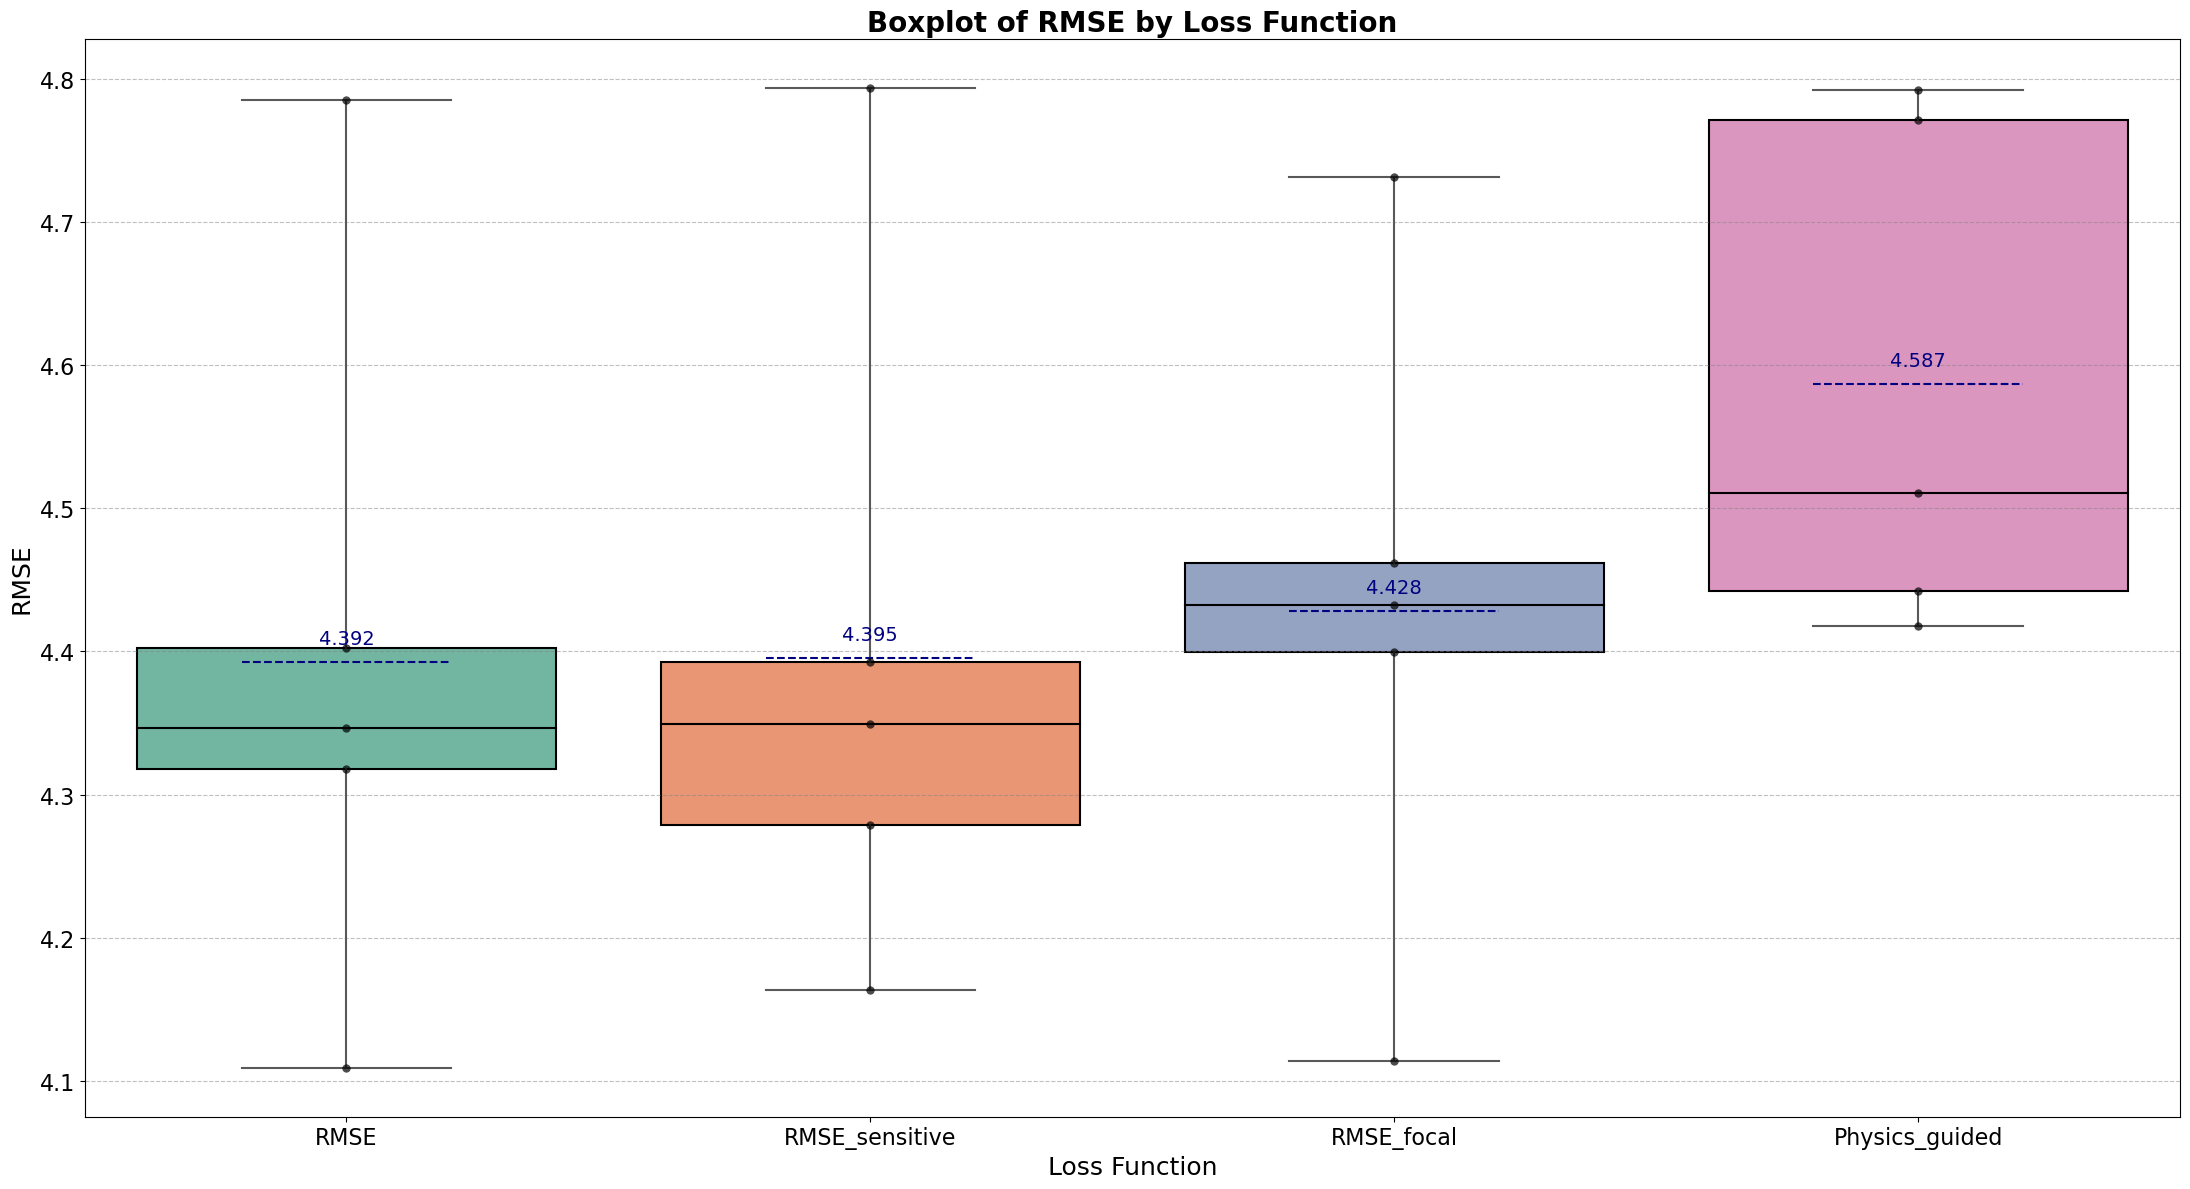

In [172]:
filtered_data = filtered_data.copy()

# Crear el gráfico
plt.figure(figsize=(22, 12))

# Gráfico de caja basado en "Loss"
sns.boxplot(
    x='Loss', y='RMSE', data=filtered_data, whis=[0, 100],
    palette="Set2",  # Paleta de colores
    boxprops={"edgecolor": "black"}, medianprops={"color": "black", "linewidth": 1.5}
)

# Overlay puntos individuales
sns.stripplot(
    x='Loss', y='RMSE', data=filtered_data, jitter=False,
    dodge=True, color='black', alpha=0.7, size=6
)

# Calcular y anotar las medias por "Loss"
means = filtered_data.groupby('Loss')['RMSE'].mean()
for loss, mean in means.items():
    # Obtener la posición exacta de la categoría en el eje x
    x_pos = filtered_data['Loss'].unique().tolist().index(loss)
    
    plt.plot(
        [x_pos - 0.2, x_pos + 0.2],  # Match the boxplot width
        [mean, mean], color="navy", linestyle="--", linewidth=1.5, label=None
    )
    plt.text(
        x=x_pos, y=mean + 0.01, s=f"{mean:.3f}",  # Ajustar posición de texto
        fontsize=14, color="navy", ha='center', va='bottom'
    )

# Etiquetas y título
plt.title("Boxplot of RMSE by Loss Function", fontsize=20, color="black", fontweight="bold")
plt.xlabel("Loss Function", fontsize=18, color="black")
plt.ylabel("RMSE", fontsize=18, color="black")

# Ajuste de ticks y cuadrícula
plt.xticks(fontsize=16, color="black")
plt.yticks(fontsize=16, color="black")
plt.grid(axis='y', linestyle='--', alpha=0.5, color="gray")

plt.tight_layout()
plt.savefig('../plots/loss_vs_rmse.png')
plt.show()


# Variables experimentation

In [173]:
filtered_data = simple_cnn[
            (simple_cnn.Resolution == 128) &
            (simple_cnn['Batch size']== 128) &
            (simple_cnn.Optimizer == 'Adam') &
            (simple_cnn['nº samples'] == '784 images') &
            (simple_cnn['Loss'] == 'RMSE') &
            (simple_cnn['Normalized Variables'] != 'Full Features')
            ]

filtered_data_2 = simple_cnn[
            (simple_cnn.Resolution == 128) &
            (simple_cnn['Batch size']== 128) &
            (simple_cnn.Optimizer == 'Adam') &
            (simple_cnn['nº samples'] == '784 images') &
            (simple_cnn['Loss'] == 'RMSE_sensitive') &
            (simple_cnn['Normalized Variables'] != 'Full Features')
            ]

In [175]:
filtered_data = simple_cnn[
            (simple_cnn.Resolution == 128) &
            (simple_cnn['Batch size']== 128) &
            (simple_cnn.Optimizer == 'Adam') &
            (simple_cnn['nº samples'] == '784 images') &
            (simple_cnn['Normalized Variables'] != 'Full Features')
            ]
filtered_data

,Experiment,RMSE,Variables,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
90,126,4.109246,lst,1,Adam,784 images,128,75 of 300,2024-12-11,18:14:40,130.26,RMSE,128,LST
91,126,4.785328,lst,2,Adam,784 images,128,63 of 300,2024-12-11,18:16:31,110.07,RMSE,128,LST
93,126,4.346643,lst,3,Adam,784 images,128,77 of 300,2024-12-11,18:18:45,132.68,RMSE,128,LST
94,126,4.318129,lst,4,Adam,784 images,128,148 of 300,2024-12-11,18:23:07,261.06,RMSE,128,LST
96,126,4.402462,lst,5,Adam,784 images,128,134 of 300,2024-12-11,18:27:04,235.67,RMSE,128,LST
124,125,4.163678,lst,1,Adam,784 images,128,75 of 300,2024-12-12,16:13:36,152.54,RMSE_sensitive,128,LST
125,125,4.114296,lst,1,Adam,784 images,128,100 of 300,2024-12-12,16:14:06,200.97,RMSE_focal,128,LST
127,125,4.793154,lst,2,Adam,784 images,128,66 of 300,2024-12-12,16:15:48,130.86,RMSE_sensitive,128,LST
128,125,4.730996,lst,2,Adam,784 images,128,70 of 300,2024-12-12,16:16:25,137.96,RMSE_focal,128,LST
129,125,4.432616,lst,3,Adam,784 images,128,56 of 300,2024-12-12,16:18:15,108.71,RMSE_focal,128,LST


In [113]:
simple_cnn[simple_cnn['Normalized Variables'] == 'Full Features']['RMSE'].std()

1883.0907886416867

In [112]:
simple_cnn[simple_cnn['Normalized Variables'] == 'Full Features']

,Experiment,RMSE,Variables,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
151,152,5177.780616,"lst, ndvi, slope, altitude, direction, month, ...",1,Adam,784 images,128,61 of 300,2024-12-13,15:40:46,129.90,RMSE,128,Full Features
152,153,358.705400,"lst, ndvi, slope, altitude, direction, month, ...",1,Adam,784 images,128,80 of 300,2024-12-13,16:39:00,164.44,RMSE,128,Full Features
153,153,1157.690422,"lst, ndvi, slope, altitude, direction, month, ...",2,Adam,784 images,128,53 of 300,2024-12-13,16:40:50,107.43,RMSE,128,Full Features
154,153,381.707807,"lst, ndvi, slope, altitude, direction, month, ...",3,Adam,784 images,128,99 of 300,2024-12-13,16:44:24,210.93,RMSE,128,Full Features
160,153,1100.086767,"lst, ndvi, slope, altitude, direction, month, ...",4,Adam,784 images,128,101 of 300,2024-12-13,16:48:23,236.06,RMSE,128,Full Features
162,153,2961.196222,"lst, ndvi, slope, altitude, direction, month, ...",5,Adam,784 images,128,44 of 300,2024-12-13,16:50:09,102.75,RMSE,128,Full Features


/var/folders/lx/01q73krn1md9zqcwvy3rqlqh0000gn/T/ipykernel_6958/3493612732.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Normalized Variables'] = filtered_data['Normalized Variables'].astype(str)
/var/folders/lx/01q73krn1md9zqcwvy3rqlqh0000gn/T/ipykernel_6958/3493612732.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Normalized Variables'] = pd.Categorical(filtered_data['Normalized Variables'], categories=ordered_categories, ordered=True)


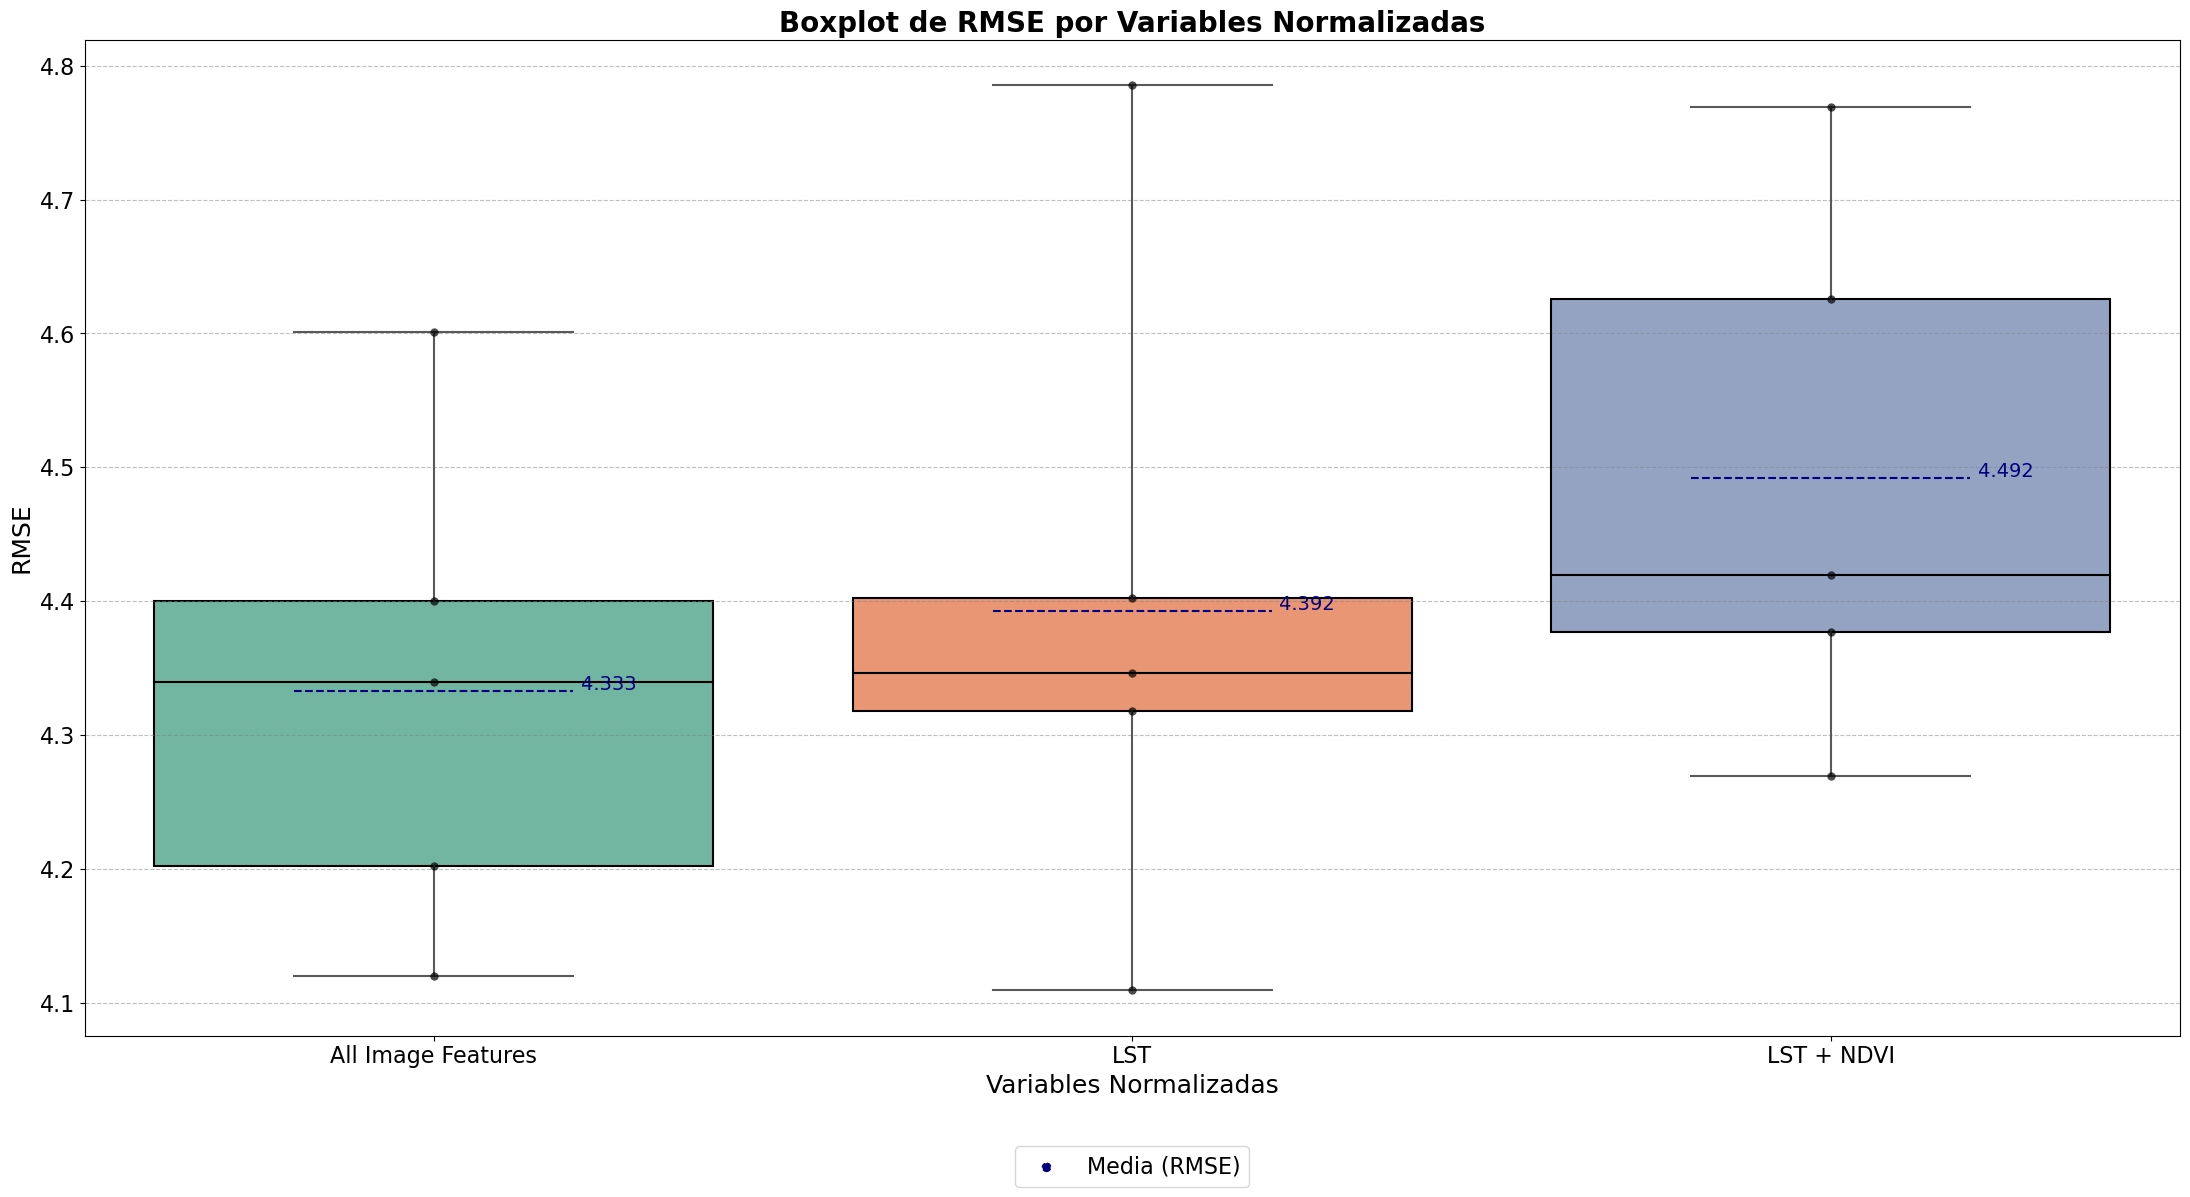

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asegúrate de que 'Normalized Variables' son cadenas
filtered_data['Normalized Variables'] = filtered_data['Normalized Variables'].astype(str)

# Calcular medias por "Normalized Variables" y ordenar
means = filtered_data.groupby('Normalized Variables')['RMSE'].mean()
ordered_categories = means.sort_values().index  # Ordenar por la media de RMSE

# Reorganizar el DataFrame según las categorías ordenadas
filtered_data['Normalized Variables'] = pd.Categorical(filtered_data['Normalized Variables'], categories=ordered_categories, ordered=True)

# Crear la figura
plt.figure(figsize=(22, 12))

# Boxplot basado en "Normalized Variables"
sns.boxplot(
    x='Normalized Variables', y='RMSE', data=filtered_data, whis=[0, 100],
    palette="Set2",  # Paleta para datos categóricos
    boxprops={"edgecolor": "black"}, medianprops={"color": "black", "linewidth": 1.5}
)

# Overlay de puntos individuales sin jitter (alineados rectos)
sns.stripplot(
    x='Normalized Variables', y='RMSE', data=filtered_data, jitter=False,  # Desactivar jitter
    dodge=False, color='black', alpha=0.7, size=6
)

# Calcular y anotar medias por "Normalized Variables"
for var, mean in means.items():
    # Usar valores únicos y ordenados de las variables
    x_pos = ordered_categories.get_loc(var)  # Obtener la posición ordenada
    plt.plot(
        [x_pos - 0.2, x_pos + 0.2],  # Ajustar el ancho del boxplot
        [mean, mean], color="navy", linestyle="--", linewidth=1.5, label=None
    )
    plt.text(
        x=x_pos + 0.25, y=mean + 0.001, s=f"{mean:.3f}",  # Anotar la media
        fontsize=14, color="navy", ha='center'
    )

# Ajustar la leyenda
plt.scatter([], [], color="navy", linestyle="--", label="Mean (RMSE)")
plt.legend(
    loc='upper center',  
    bbox_to_anchor=(0.5, -0.1), 
    fontsize=16,  
    ncol=1
)

# Etiquetas y título
plt.title("Boxplot of RMSE by Variables Combination", fontsize=20, color="black", fontweight="bold")
plt.xlabel("Variables", fontsize=18, color="black")
plt.ylabel("RMSE", fontsize=18, color="black")

# Ajustes de ticks y grid
plt.xticks(fontsize=16, color="black")
plt.yticks(fontsize=16, color="black")
plt.grid(axis='y', linestyle='--', alpha=0.5, color="gray")

plt.tight_layout()
#plt.savefig('../plots/normalized_variables_vs_rmse.png')
plt.show()


/var/folders/lx/01q73krn1md9zqcwvy3rqlqh0000gn/T/ipykernel_6958/1108228866.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Normalized Variables'] = filtered_data['Normalized Variables'].astype(str)
/var/folders/lx/01q73krn1md9zqcwvy3rqlqh0000gn/T/ipykernel_6958/1108228866.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_2['Normalized Variables'] = filtered_data_2['Normalized Variables'].astype(str)
/var/folders/lx/01q73krn1md9zqcwvy3rqlqh0000gn/T/ipykernel_6958/1108228866

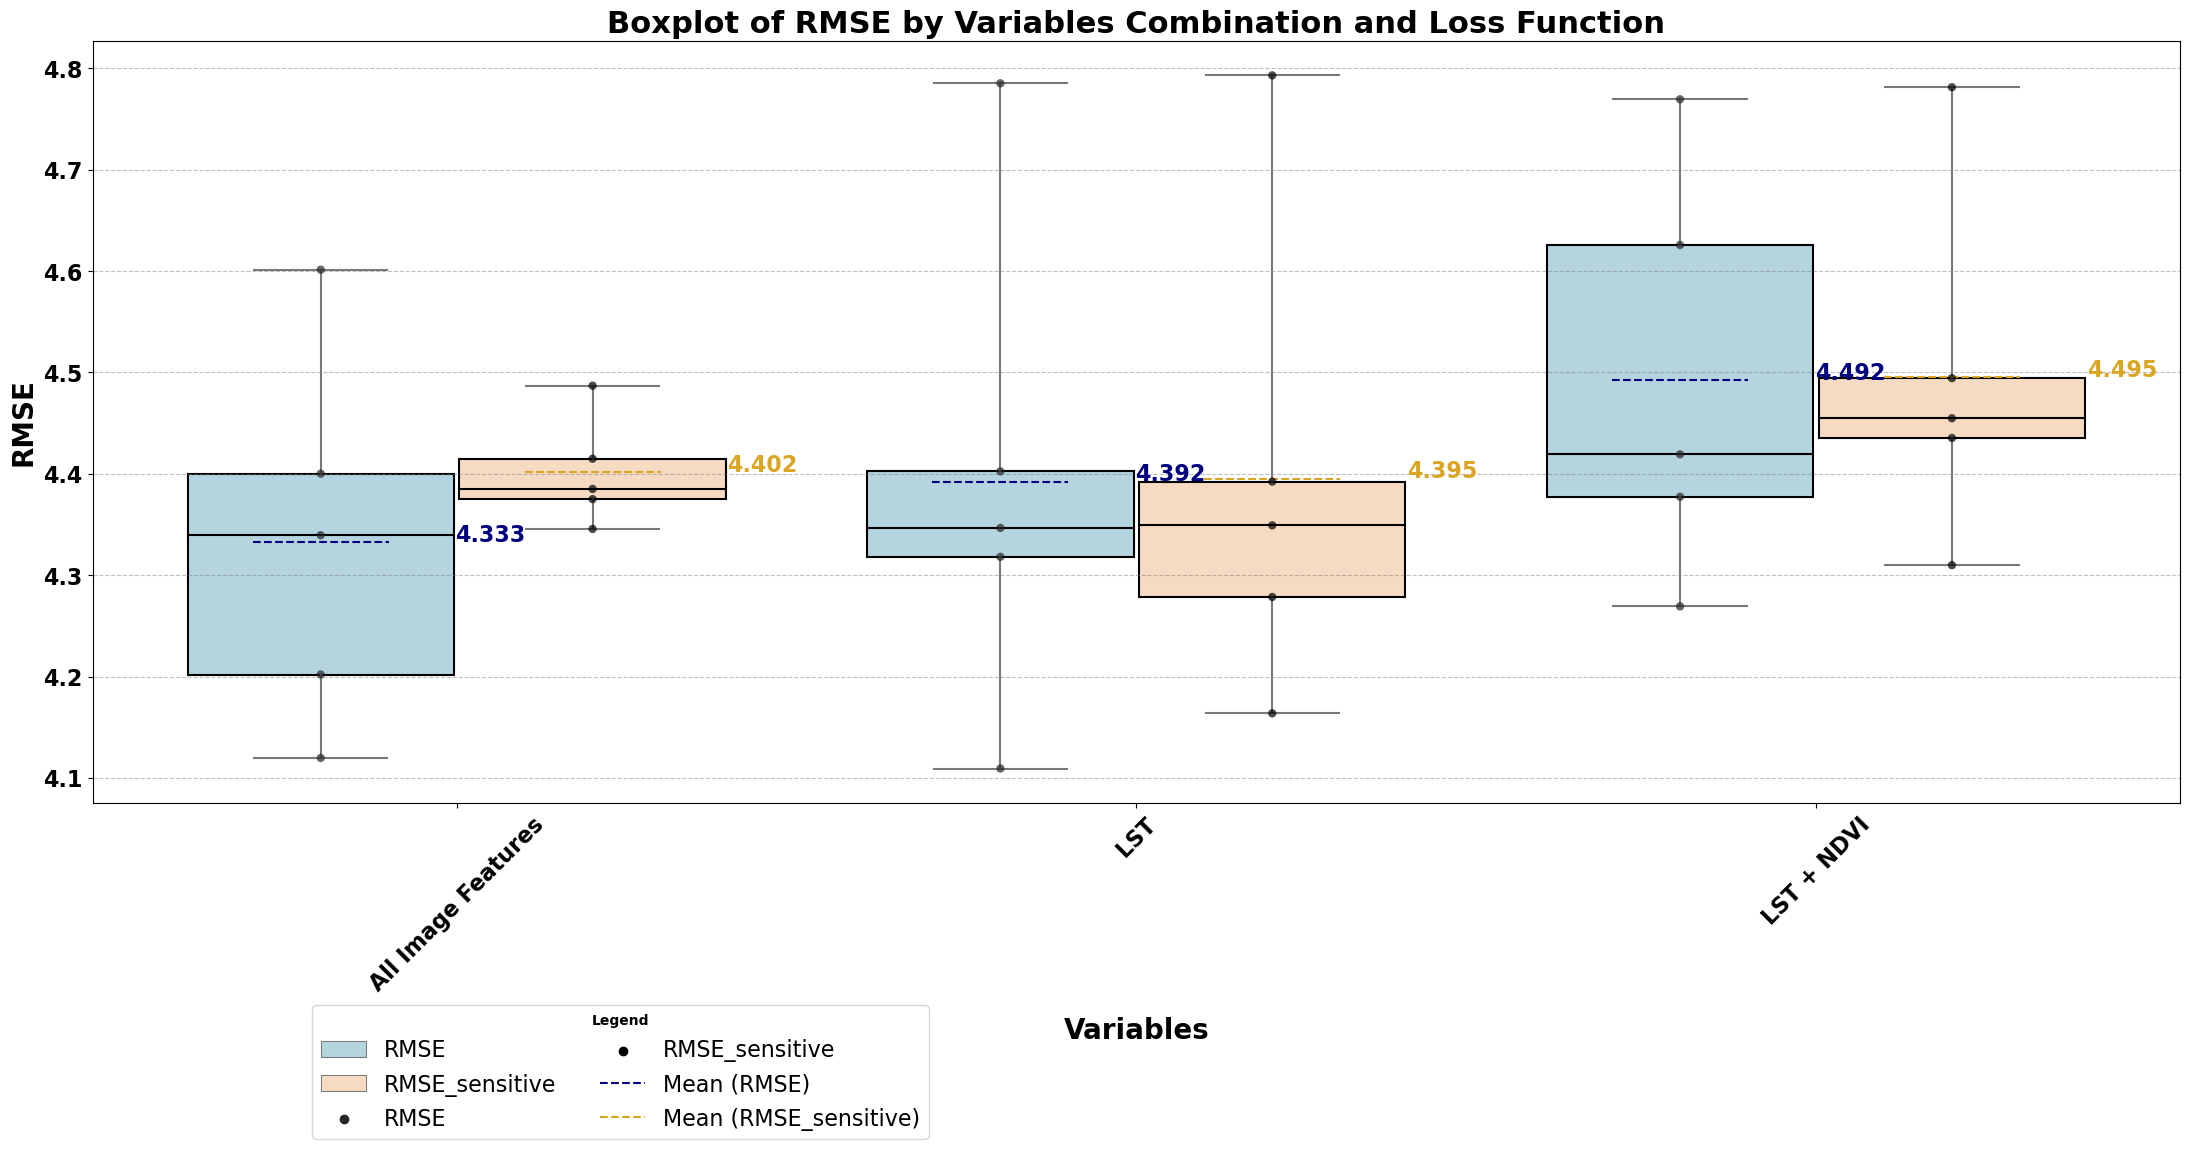

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asegúrate de que 'Normalized Variables' son cadenas en ambos DataFrames
filtered_data['Normalized Variables'] = filtered_data['Normalized Variables'].astype(str)
filtered_data_2['Normalized Variables'] = filtered_data_2['Normalized Variables'].astype(str)

# Añadir columna para identificar la loss function
filtered_data['Loss Function'] = 'RMSE'
filtered_data_2['Loss Function'] = 'RMSE_sensitive'

# Combinar los dos DataFrames
combined_data = pd.concat([filtered_data, filtered_data_2])

# Calcular medias por "Normalized Variables" y por Loss Function
means = combined_data.groupby(['Normalized Variables', 'Loss Function'])['RMSE'].mean().unstack()

# Ordenar categorías por la media de RMSE para la primera Loss Function ('RMSE')
ordered_categories = means['RMSE'].sort_values().index
combined_data['Normalized Variables'] = pd.Categorical(
    combined_data['Normalized Variables'], categories=ordered_categories, ordered=True
)

# Crear la figura
plt.figure(figsize=(22, 12))

# Boxplot basado en "Normalized Variables" y diferenciando por 'Loss Function'
sns.boxplot(
    x='Normalized Variables', y='RMSE', hue='Loss Function', data=combined_data, whis=[0, 100],
    palette={"RMSE": "#ADD8E6", "RMSE_sensitive": "#FFDAB9"},  # Colores generales para las pérdidas
    boxprops={"edgecolor": "black"}, medianprops={"color": "black", "linewidth": 1.5}
)

# Overlay de puntos individuales sin jitter (alineados rectos)
sns.stripplot(
    x='Normalized Variables', y='RMSE', hue='Loss Function', data=combined_data, jitter=False,
    dodge=True, color='black', alpha=0.7, size=6
)

# Calcular y anotar medias para cada combinación de Variable y Loss Function
for loss_function in combined_data['Loss Function'].unique():  # Iterar por las pérdidas
    loss_data = combined_data[combined_data['Loss Function'] == loss_function]
    means = loss_data.groupby('Normalized Variables')['RMSE'].mean()
    offset = -0.2 if loss_function == 'RMSE' else 0.2  # Desplazar ligeramente las líneas

    for var, mean in means.items():
        x_pos = ordered_categories.get_loc(var)  # Posición ordenada en el eje X
        plt.plot(
            [x_pos + offset - 0.1, x_pos + offset + 0.1],  # Ajustar la posición de la línea
            [mean, mean], color="navy" if loss_function == 'RMSE' else "goldenrod",
            linestyle="--", linewidth=1.5, label=None
        )
        plt.text(
            x=x_pos + offset + 0.25, y=mean + 0.001, s=f"{mean:.3f}",
            fontsize=16, fontweight="bold", color="navy" if loss_function == 'RMSE' else "goldenrod", ha='center'
        )

# Refinar la leyenda
plt.plot([], [], color="navy", linestyle="--", label="Mean (RMSE)")
plt.plot([], [], color="goldenrod", linestyle="--", label="Mean (RMSE_sensitive)")
legend = plt.legend(
    loc='upper left', bbox_to_anchor=(0.1, -0.25),  # Move further left and down
    fontsize=16, ncol=2, frameon=True, title="Legend"
)

# Ajustar manualmente el estilo del título de la leyenda
legend.get_title().set_fontweight("bold")

# Etiquetas y título
plt.title("Boxplot of RMSE by Variables Combination and Loss Function", fontsize=22, color="black", fontweight="bold")
plt.xlabel("Variables", fontsize=20, color="black", fontweight="bold", labelpad=15)  # Add padding for more space
plt.ylabel("RMSE", fontsize=20, color="black", fontweight="bold")

# Ajustes de ticks y grid
plt.xticks(fontsize=16, rotation=45, color="black", fontweight="bold")  # Rotate for clarity
plt.yticks(fontsize=16, color="black", fontweight="bold")
plt.grid(axis='y', linestyle='--', alpha=0.5, color="gray")

# Ensure there's enough space for everything
plt.tight_layout()
# plt.savefig('../plots/normalized_variables_vs_rmse_loss_comparison.png')
plt.show()



# Model architecture experimentation

In [96]:
simple_cnn['Normalized Variables'].unique()

array(['LST', 'LST + NDVI', 'All Image Features', 'Full Features'],
      dtype=object)

In [115]:
model= 'CNN_2'
cnn_2 = pd.read_excel(f'../official_results/{model}_results.xlsx')
cnn_2['Normalized Variables'] = cnn_2['Variables'].apply(
    lambda x: ', '.join(sorted(x.split(', '))))
print(cnn_2['Normalized Variables'].unique())
cnn_2['Normalized Variables'] = cnn_2['Normalized Variables'].map(variable_set_mapping)
cnn_2

['altitude, direction, lst, ndvi, slope'
 'altitude, coords, direction, discharge, lst, month, ndvi, slope']


,Experiment,RMSE,Variables,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
0,1,4.795339,"lst, ndvi, slope, altitude, direction",1,Adam,784 images,128,110 of 300,2024-12-29,13:37:32,239.29,RMSE_sensitive,128,All Image Features
1,1,4.707077,"lst, ndvi, slope, altitude, direction",1,Adam,784 images,128,110 of 300,2024-12-29,13:37:55,258.49,RMSE,128,All Image Features
2,1,4.692249,"lst, ndvi, slope, altitude, direction",2,Adam,784 images,128,130 of 300,2024-12-29,13:42:54,295.89,RMSE,128,All Image Features
3,1,5.146987,"lst, ndvi, slope, altitude, direction",2,Adam,784 images,128,174 of 300,2024-12-29,13:43:53,377.98,RMSE_sensitive,128,All Image Features
4,1,4.718394,"lst, ndvi, slope, altitude, direction",3,Adam,784 images,128,115 of 300,2024-12-29,13:47:18,260.73,RMSE,128,All Image Features
5,1,4.813854,"lst, ndvi, slope, altitude, direction",3,Adam,784 images,128,117 of 300,2024-12-29,13:48:06,250.53,RMSE_sensitive,128,All Image Features
6,1,4.720303,"lst, ndvi, slope, altitude, direction",4,Adam,784 images,128,125 of 300,2024-12-29,13:52:06,285.10,RMSE,128,All Image Features
7,1,5.374976,"lst, ndvi, slope, altitude, direction",4,Adam,784 images,128,121 of 300,2024-12-29,13:52:29,260.09,RMSE_sensitive,128,All Image Features
8,1,4.821506,"lst, ndvi, slope, altitude, direction",5,Adam,784 images,128,107 of 300,2024-12-29,13:56:24,233.12,RMSE_sensitive,128,All Image Features
9,1,4.772887,"lst, ndvi, slope, altitude, direction",5,Adam,784 images,128,121 of 300,2024-12-29,13:56:49,279.57,RMSE,128,All Image Features


In [116]:
model= 'CNN_3'
cnn_3 = pd.read_excel(f'../official_results/{model}_results.xlsx')
cnn_3['Normalized Variables'] = cnn_3['Variables'].apply(
    lambda x: ', '.join(sorted(x.split(', '))))
print(cnn_3['Normalized Variables'].unique())
cnn_3['Normalized Variables'] = cnn_3['Normalized Variables'].map(variable_set_mapping)
cnn_3

['altitude, direction, lst, ndvi, slope'
 'altitude, coords, direction, discharge, lst, month, ndvi, slope']


,Experiment,RMSE,Variables,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
0,1,6.277464,"lst, ndvi, slope, altitude, direction",1,Adam,784 images,128,94 of 300,2024-12-29,14:00:05,218.46,RMSE_sensitive,128,All Image Features
1,1,5.149650,"lst, ndvi, slope, altitude, direction",1,Adam,784 images,128,93 of 300,2024-12-29,14:00:32,220.51,RMSE,128,All Image Features
2,1,5.858463,"lst, ndvi, slope, altitude, direction",2,Adam,784 images,128,140 of 300,2024-12-29,14:06:02,327.33,RMSE,128,All Image Features
3,1,5.887884,"lst, ndvi, slope, altitude, direction",2,Adam,784 images,128,142 of 300,2024-12-29,14:06:10,362.01,RMSE_sensitive,128,All Image Features
4,1,5.852146,"lst, ndvi, slope, altitude, direction",3,Adam,784 images,128,92 of 300,2024-12-29,14:09:38,213.21,RMSE,128,All Image Features
5,1,5.976340,"lst, ndvi, slope, altitude, direction",3,Adam,784 images,128,144 of 300,2024-12-29,14:12:11,357.38,RMSE_sensitive,128,All Image Features
6,1,6.072201,"lst, ndvi, slope, altitude, direction",4,Adam,784 images,128,103 of 300,2024-12-29,14:13:31,231.20,RMSE,128,All Image Features
7,1,5.926339,"lst, ndvi, slope, altitude, direction",4,Adam,784 images,128,86 of 300,2024-12-29,14:15:39,205.04,RMSE_sensitive,128,All Image Features
8,1,5.167853,"lst, ndvi, slope, altitude, direction",5,Adam,784 images,128,90 of 300,2024-12-29,14:16:54,199.85,RMSE,128,All Image Features
9,1,5.532080,"lst, ndvi, slope, altitude, direction",5,Adam,784 images,128,104 of 300,2024-12-29,14:19:46,243.60,RMSE_sensitive,128,All Image Features


In [118]:
model= 'Resnet'
resnet = pd.read_excel(f'../official_results/{model}_results.xlsx')
resnet['Normalized Variables'] = resnet['Variables'].apply(
    lambda x: ', '.join(sorted(x.split(', '))))
print(resnet['Normalized Variables'].unique())
resnet['Normalized Variables'] = resnet['Normalized Variables'].map(variable_set_mapping)
resnet

['altitude, direction, lst, ndvi, slope'
 'altitude, coords, direction, discharge, lst, month, ndvi, slope']


,Experiment,RMSE,Variables,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
0,1,4.643790,"lst, ndvi, slope, altitude, direction",1,Adam,784 images,128,88 of 300,2024-12-29,14:21:57,301.19,RMSE,128,All Image Features
1,1,4.835977,"lst, ndvi, slope, altitude, direction",1,Adam,784 images,128,111 of 300,2024-12-29,14:26:36,407.66,RMSE_sensitive,128,All Image Features
2,1,4.985665,"lst, ndvi, slope, altitude, direction",2,Adam,784 images,128,134 of 300,2024-12-29,14:29:44,463.80,RMSE,128,All Image Features
3,1,5.039595,"lst, ndvi, slope, altitude, direction",2,Adam,784 images,128,110 of 300,2024-12-29,14:33:20,400.64,RMSE_sensitive,128,All Image Features
4,1,4.747771,"lst, ndvi, slope, altitude, direction",3,Adam,784 images,128,131 of 300,2024-12-29,14:37:10,443.29,RMSE,128,All Image Features
5,1,4.782483,"lst, ndvi, slope, altitude, direction",3,Adam,784 images,128,94 of 300,2024-12-29,14:39:07,343.57,RMSE_sensitive,128,All Image Features
6,1,5.226076,"lst, ndvi, slope, altitude, direction",4,Adam,784 images,128,148 of 300,2024-12-29,14:45:41,508.41,RMSE,128,All Image Features
7,1,4.870394,"lst, ndvi, slope, altitude, direction",4,Adam,784 images,128,156 of 300,2024-12-29,14:48:39,568.84,RMSE_sensitive,128,All Image Features
8,1,4.833048,"lst, ndvi, slope, altitude, direction",5,Adam,784 images,128,100 of 300,2024-12-29,14:51:25,341.17,RMSE,128,All Image Features
9,1,4.782134,"lst, ndvi, slope, altitude, direction",5,Adam,784 images,128,71 of 300,2024-12-29,14:52:53,249.71,RMSE_sensitive,128,All Image Features


In [119]:
model= 'transfer_resnet'
transfer_resnet = pd.read_excel(f'../official_results/{model}_results.xlsx')
transfer_resnet['Normalized Variables'] = transfer_resnet['Variables'].apply(
    lambda x: ', '.join(sorted(x.split(', '))))
print(transfer_resnet['Normalized Variables'].unique())
transfer_resnet['Normalized Variables'] = transfer_resnet['Normalized Variables'].map(variable_set_mapping)
transfer_resnet

['altitude, direction, lst, ndvi, slope'
 'altitude, coords, direction, discharge, lst, month, ndvi, slope']


,Experiment,RMSE,Variables,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
0,1,4.533147,"lst, ndvi, slope, altitude, direction",1,Adam,784 images,128,32 of 300,2024-12-29,14:52:40,70.91,RMSE,128,All Image Features
1,1,5.615825,"lst, ndvi, slope, altitude, direction",2,Adam,784 images,128,32 of 300,2024-12-29,14:53:54,69.46,RMSE,128,All Image Features
2,2,4.538865,"lst, ndvi, slope, altitude, direction",1,Adam,784 images,128,32 of 300,2024-12-29,14:54:03,67.29,RMSE_sensitive,128,All Image Features
3,1,5.271048,"lst, ndvi, slope, altitude, direction",3,Adam,784 images,128,51 of 300,2024-12-29,14:55:51,113.00,RMSE,128,All Image Features
4,2,5.181842,"lst, ndvi, slope, altitude, direction",2,Adam,784 images,128,60 of 300,2024-12-29,14:56:09,122.31,RMSE_sensitive,128,All Image Features
5,1,5.376226,"lst, ndvi, slope, altitude, direction",4,Adam,784 images,128,31 of 300,2024-12-29,14:57:04,68.93,RMSE,128,All Image Features
6,2,4.661883,"lst, ndvi, slope, altitude, direction",3,Adam,784 images,128,40 of 300,2024-12-29,14:57:42,88.98,RMSE_sensitive,128,All Image Features
7,1,4.794356,"lst, ndvi, slope, altitude, direction",5,Adam,784 images,128,69 of 300,2024-12-29,14:59:49,160.26,RMSE,128,All Image Features
8,2,4.589879,"lst, ndvi, slope, altitude, direction",4,Adam,784 images,128,92 of 300,2024-12-29,15:01:09,204.15,RMSE_sensitive,128,All Image Features
9,2,4.769403,"lst, ndvi, slope, altitude, direction",5,Adam,784 images,128,31 of 300,2024-12-29,15:02:11,58.32,RMSE_sensitive,128,All Image Features


/var/folders/lx/01q73krn1md9zqcwvy3rqlqh0000gn/T/ipykernel_6958/1984087099.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Normalized Variables'] = filtered_data['Normalized Variables'].astype(str)
/Users/ruthparajo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


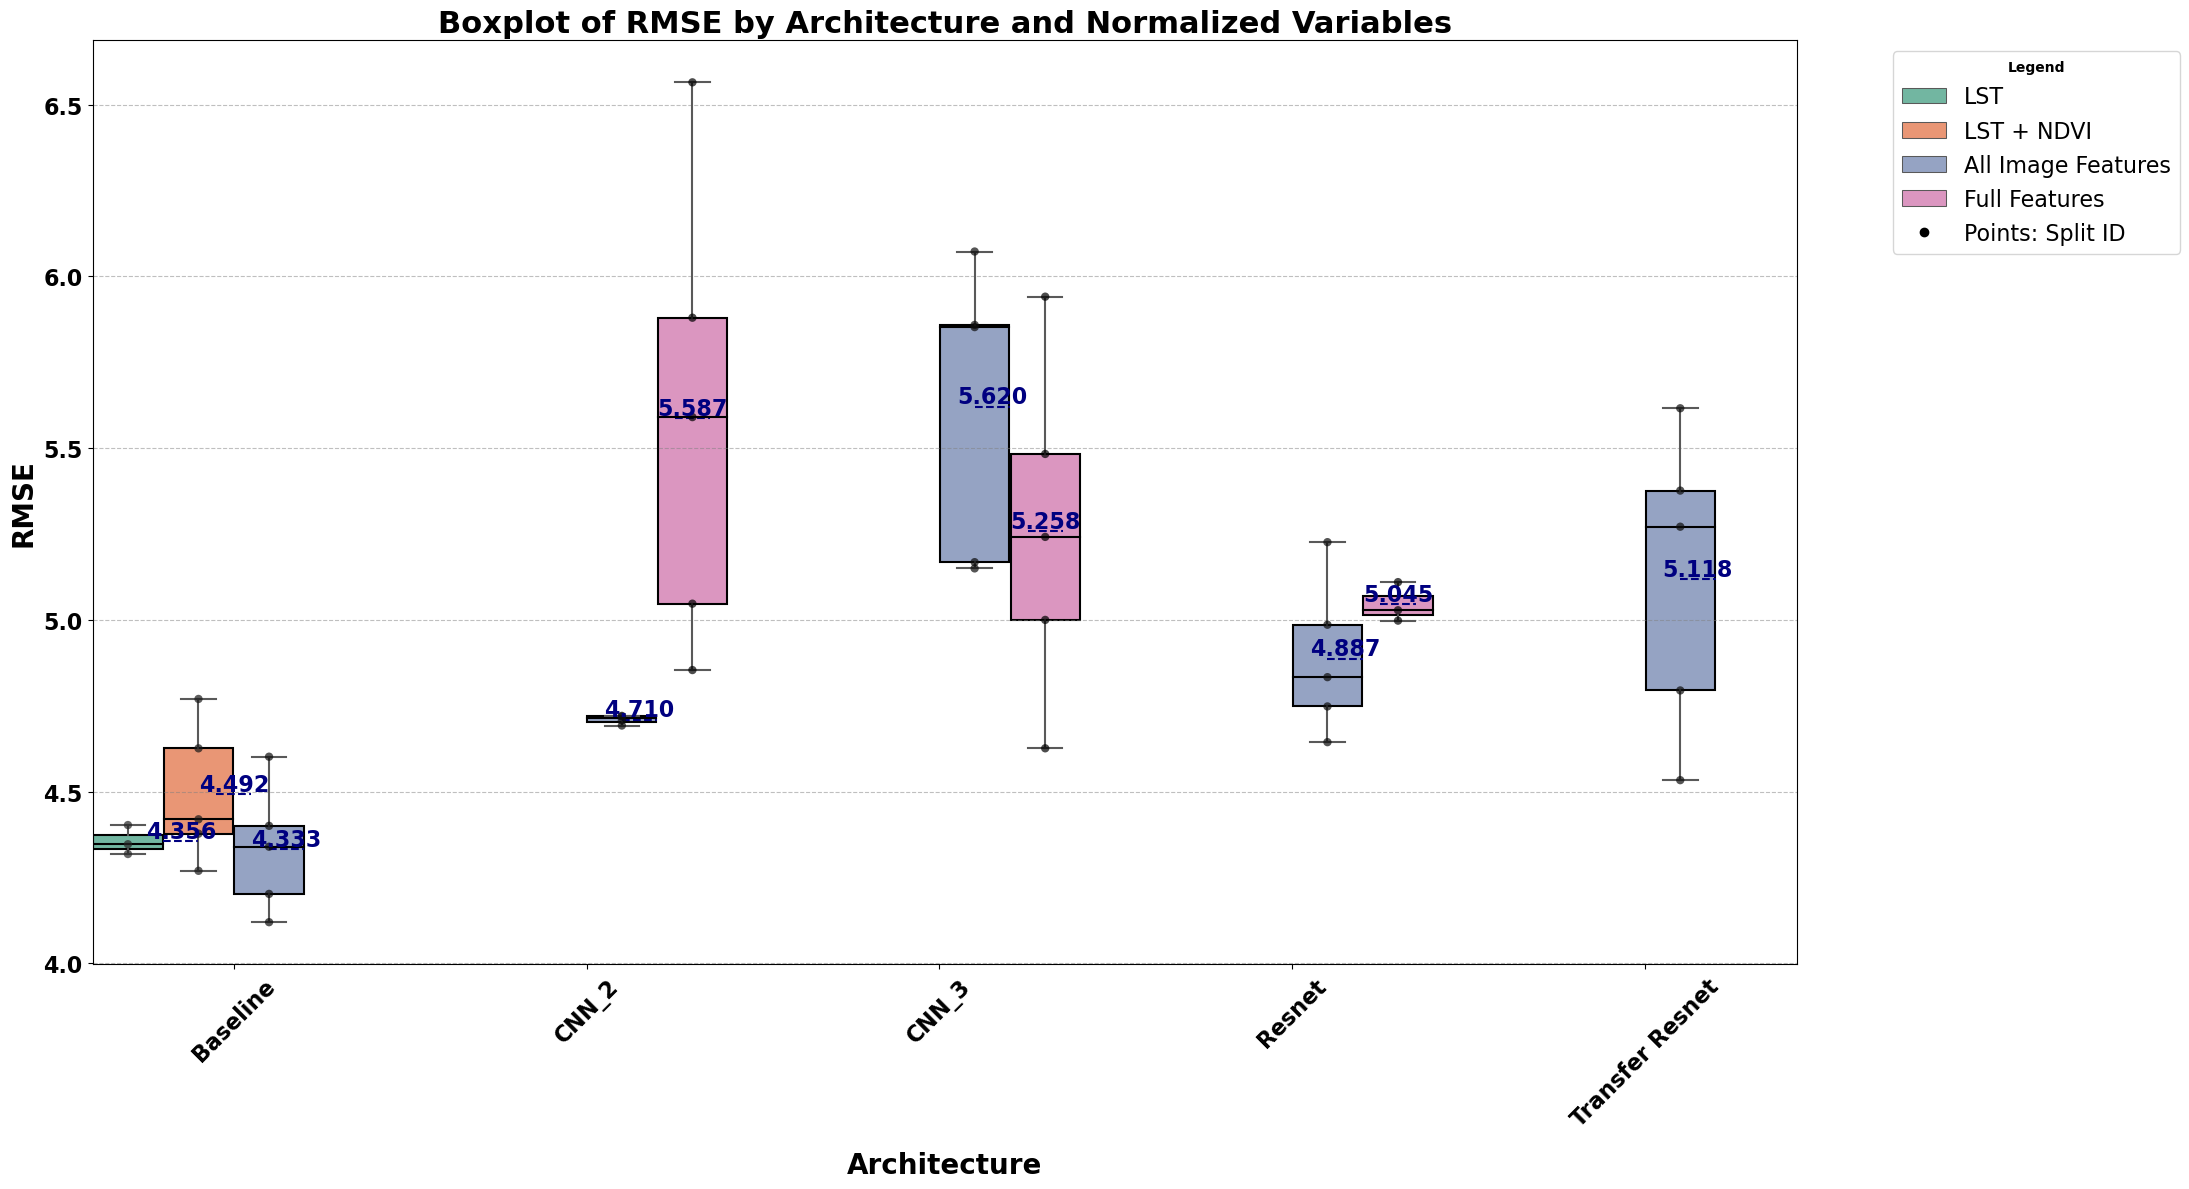

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine all dataframes into one with an additional column to indicate the architecture
simple_cnn = simple_cnn.copy()

simple_cnn = simple_cnn[
    (simple_cnn.Resolution == 128) &
    (simple_cnn['Batch size'] == 128) &
    (simple_cnn.Optimizer == 'Adam') &
    (simple_cnn['nº samples'] == '784 images') &
    (simple_cnn['Loss'] == 'RMSE') &
    (simple_cnn['Normalized Variables'] != 'Full Features')
]

transfer_resnet = transfer_resnet.copy()
transfer_resnet = transfer_resnet[transfer_resnet['Normalized Variables'] != 'Full Features']

simple_cnn['Architecture'] = 'Baseline'
cnn_2['Architecture'] = 'CNN_2'
cnn_3['Architecture'] = 'CNN_3'
resnet['Architecture'] = 'Resnet'
transfer_resnet['Architecture'] = 'Transfer Resnet'

# Combine all datasets
combined_data = pd.concat([simple_cnn, cnn_2, cnn_3, resnet, transfer_resnet])

# Filter only the rows with the "RMSE" loss function
filtered_data = combined_data[combined_data['Loss'] == 'RMSE']

# Ensure 'Normalized Variables' is treated as categorical
filtered_data['Normalized Variables'] = filtered_data['Normalized Variables'].astype(str)

# Calculate IQR for each architecture and variable combination
Q1 = filtered_data.groupby(['Architecture', 'Normalized Variables'])['RMSE'].quantile(0.25)
Q3 = filtered_data.groupby(['Architecture', 'Normalized Variables'])['RMSE'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for non-outlier values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Join bounds back to the data
bounds = pd.DataFrame({'lower': lower_bound, 'upper': upper_bound}).reset_index()
filtered_data = pd.merge(filtered_data, bounds, on=['Architecture', 'Normalized Variables'])

# Filter out outliers
filtered_data = filtered_data[
    (filtered_data['RMSE'] >= filtered_data['lower']) & 
    (filtered_data['RMSE'] <= filtered_data['upper'])
]

# Define the desired order for architectures
desired_order = ['Baseline', 'CNN_2', 'CNN_3', 'Resnet', 'Transfer Resnet']
filtered_data['Architecture'] = pd.Categorical(
    filtered_data['Architecture'], categories=desired_order, ordered=True
)

# Create the plot
plt.figure(figsize=(22, 12))

# Boxplot for each architecture and normalized variable
sns.boxplot(
    x='Architecture', y='RMSE', hue='Normalized Variables', data=filtered_data, whis=[0, 100],
    palette="Set2",  # Use a categorical color palette
    boxprops={"edgecolor": "black"}, medianprops={"color": "black", "linewidth": 1.5}
)

# Overlay stripplot for individual data points
sns.stripplot(
    x='Architecture', y='RMSE', hue='Normalized Variables', data=filtered_data, jitter=False,
    dodge=True, color='black', alpha=0.7, size=6
)

# Calculate and annotate means for each architecture and normalized variable
for arch in desired_order:
    arch_data = filtered_data[filtered_data['Architecture'] == arch]
    means = arch_data.groupby('Normalized Variables')['RMSE'].mean()
    offset_map = {var: i * 0.15 - 0.15 for i, var in enumerate(filtered_data['Normalized Variables'].unique())}  # Offset map

    for var, mean in means.items():
        x_pos = desired_order.index(arch) + offset_map[var]  # Adjust position
        plt.plot(
            [x_pos - 0.05, x_pos + 0.05],  # Horizontal line for the mean
            [mean, mean], color="navy", linestyle="--", linewidth=1.5, label=None
        )
        plt.text(
            x=x_pos, y=mean + 0.01, s=f"{mean:.3f}",
            fontsize=16, fontweight="bold", color="navy", ha='center'
        )

# Remove the automatic stripplot legend entries by re-adding only the boxplot colors
handles, labels = plt.gca().get_legend_handles_labels()

# Filter the handles to keep only the boxplots (normalized variables)
boxplot_handles = handles[:len(filtered_data['Normalized Variables'].unique())]  # First entries are boxplot colors
boxplot_labels = labels[:len(filtered_data['Normalized Variables'].unique())]

# Add a custom legend entry for "Points: Split ID"
boxplot_handles.append(plt.Line2D([0], [0], marker='o', color='black', linestyle='', label='Points: Split ID'))
boxplot_labels.append("Points: Split ID")

# Update the legend
plt.legend(
    handles=boxplot_handles,
    labels=boxplot_labels,
    loc='upper left', bbox_to_anchor=(1.05, 1), title="Legend",
    fontsize=16, frameon=True
)

# Set font weight for the legend title
legend = plt.gca().get_legend()
legend.get_title().set_fontweight("bold")

# Titles and labels
plt.title("Boxplot of RMSE by Architecture and Normalized Variables", fontsize=22, color="black", fontweight="bold")
plt.xlabel("Architecture", fontsize=20, color="black", fontweight="bold", labelpad=15)
plt.ylabel("RMSE", fontsize=20, color="black", fontweight="bold")

# Ticks and grid
plt.xticks(fontsize=16, rotation=45, color="black", fontweight="bold")
plt.yticks(fontsize=16, color="black", fontweight="bold")
plt.grid(axis='y', linestyle='--', alpha=0.5, color="gray")

# Layout adjustment
plt.tight_layout()
# Save the figure if needed
# plt.savefig('rmse_by_architecture_normalized_variables.png')
plt.show()
